# Task

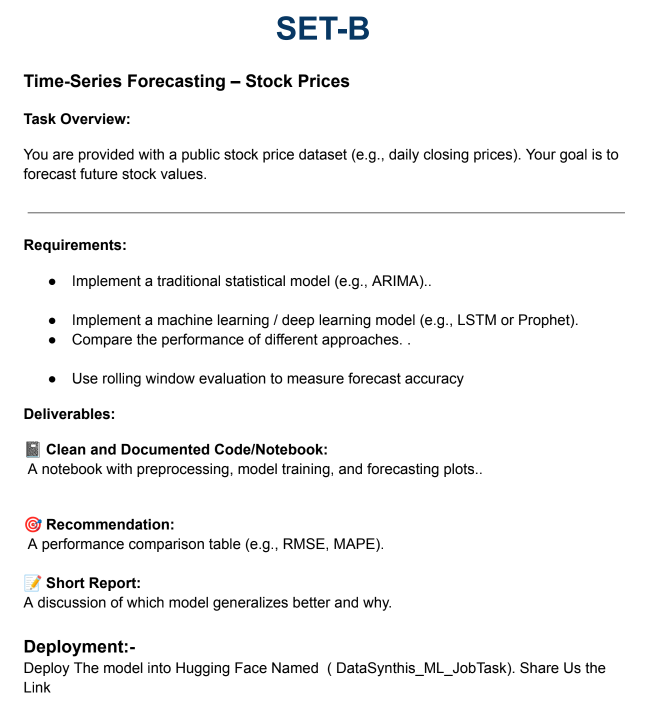



# Downloading Libraries

In [3]:
!pip install yfinance pandas numpy matplotlib seaborn statsmodels scikit-learn tensorflow

# Importing Libraries

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Dataset Details

In [5]:
# Download Tesla stock data (2010–2023 for long history)
df = yf.download("TSLA", start="2010-01-01", end="2023-12-31")
df.reset_index(inplace=True)
df.to_csv("tesla_stock_data.csv", index=False)
print("Tesla dataset downloaded and saved as tesla_stock_data.csv")
print(df.head())


/tmp/ipython-input-2004606964.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("TSLA", start="2010-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed

Tesla dataset downloaded and saved as tesla_stock_data.csv
Price        Date     Close      High       Low      Open     Volume
Ticker                 TSLA      TSLA      TSLA      TSLA       TSLA
0      2010-06-29  1.592667  1.666667  1.169333  1.266667  281494500
1      2010-06-30  1.588667  2.028000  1.553333  1.719333  257806500
2      2010-07-01  1.464000  1.728000  1.351333  1.666667  123282000
3      2010-07-02  1.280000  1.540000  1.247333  1.533333   77097000
4      2010-07-06  1.074000  1.333333  1.055333  1.333333  103003500


In [6]:
df = pd.read_csv("tesla_stock_data.csv", header=[0,1])

df.columns = [col[0] if col[0] != "Price" else col[1] for col in df.columns]

df.rename(columns={"TSLA":"Date"}, inplace=True)
df.rename(columns={
    "Close": "Close",
    "Open": "Open",
    "High": "High",
    "Low": "Low",
    "Volume": "Volume"
}, inplace=True)

df["Date"] = pd.to_datetime(df["Date"])

print(df.head())


        Date     Close      High       Low      Open     Volume
0 2010-06-29  1.592667  1.666667  1.169333  1.266667  281494500
1 2010-06-30  1.588667  2.028000  1.553333  1.719333  257806500
2 2010-07-01  1.464000  1.728000  1.351333  1.666667  123282000
3 2010-07-02  1.280000  1.540000  1.247333  1.533333   77097000
4 2010-07-06  1.074000  1.333333  1.055333  1.333333  103003500


In [7]:
df = pd.read_csv("tesla_stock_data.csv", header=[0,1])

df.columns = [col[0] if col[0] != "Price" else col[1] for col in df.columns]

df.rename(columns={"TSLA": "Date"}, inplace=True)

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3400 non-null   datetime64[ns]
 1   Close   3400 non-null   float64       
 2   High    3400 non-null   float64       
 3   Low     3400 non-null   float64       
 4   Open    3400 non-null   float64       
 5   Volume  3400 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 159.5 KB
None
        Date     Close      High       Low      Open     Volume
0 2010-06-29  1.592667  1.666667  1.169333  1.266667  281494500
1 2010-06-30  1.588667  2.028000  1.553333  1.719333  257806500
2 2010-07-01  1.464000  1.728000  1.351333  1.666667  123282000
3 2010-07-02  1.280000  1.540000  1.247333  1.533333   77097000
4 2010-07-06  1.074000  1.333333  1.055333  1.333333  103003500


## Missing and Duplicate Values

In [8]:
print("Missing values per column:")
print(df.isnull().sum())

print("Duplicate rows count:", df.duplicated().sum())

Missing values per column:
Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64
Duplicate rows count: 0


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.2)

df = pd.read_csv("tesla_stock_data.csv", header=[0,1])

df.columns = [col[0] if col[0] != "Price" else col[1] for col in df.columns]

df.rename(columns={"TSLA": "Date"}, inplace=True)

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

df.set_index("Date", inplace=True)

print("Columns available:", df.columns)
print(df.head())


Columns available: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
               Close      High       Low      Open     Volume
Date                                                         
2010-06-29  1.592667  1.666667  1.169333  1.266667  281494500
2010-06-30  1.588667  2.028000  1.553333  1.719333  257806500
2010-07-01  1.464000  1.728000  1.351333  1.666667  123282000
2010-07-02  1.280000  1.540000  1.247333  1.533333   77097000
2010-07-06  1.074000  1.333333  1.055333  1.333333  103003500


## Visualization

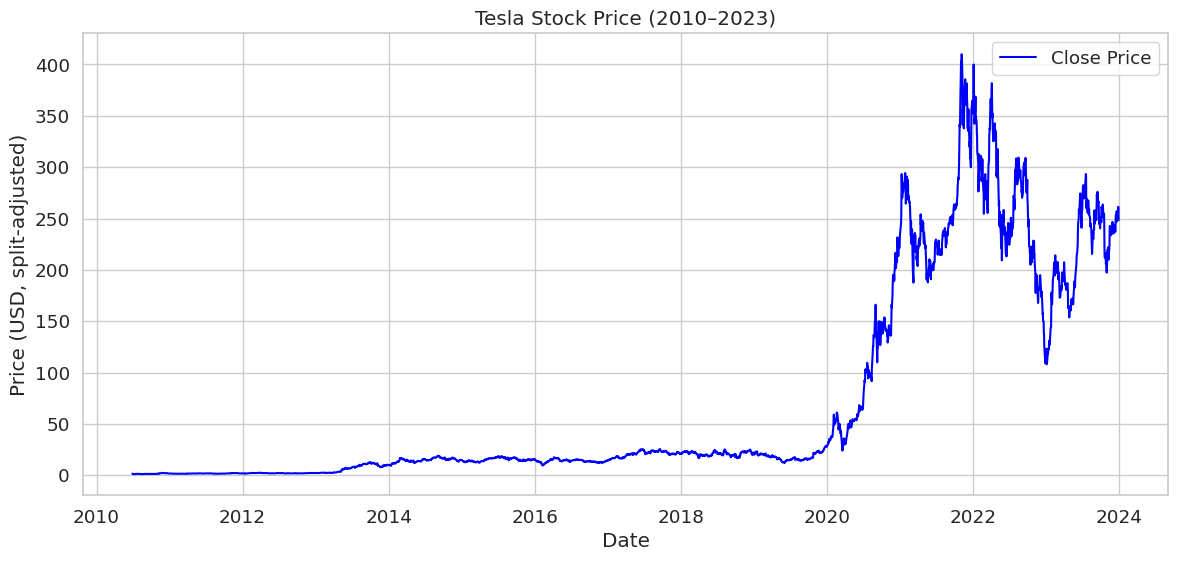

In [8]:
plt.figure(figsize=(14,6))
plt.plot(df.index, df["Close"], color="blue", label="Close Price")
plt.title("Tesla Stock Price (2010–2023)")
plt.xlabel("Date")
plt.ylabel("Price (USD, split-adjusted)")
plt.legend()
plt.show()


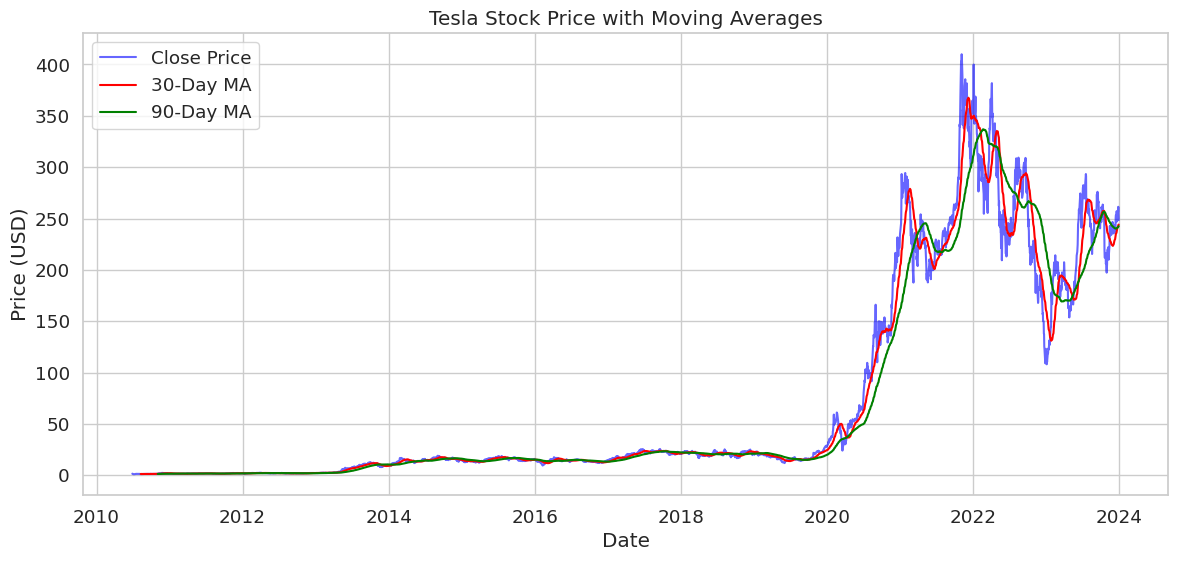

In [9]:
df["MA30"] = df["Close"].rolling(window=30).mean()   # 1-month
df["MA90"] = df["Close"].rolling(window=90).mean()   # 3-months

plt.figure(figsize=(14,6))
plt.plot(df.index, df["Close"], label="Close Price", color="blue", alpha=0.6)
plt.plot(df.index, df["MA30"], label="30-Day MA", color="red")
plt.plot(df.index, df["MA90"], label="90-Day MA", color="green")
plt.title("Tesla Stock Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


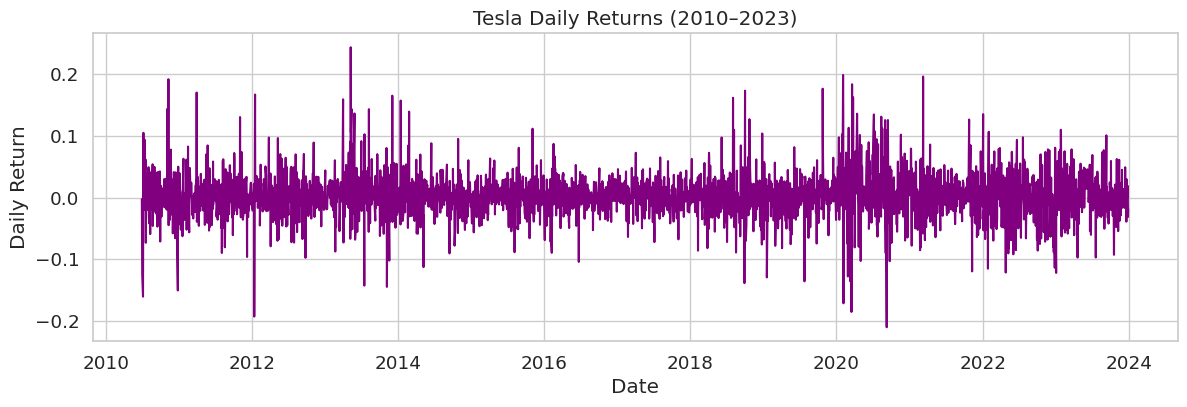

In [10]:
df["Return"] = df["Close"].pct_change()

plt.figure(figsize=(14,4))
plt.plot(df.index, df["Return"], color="purple")
plt.title("Tesla Daily Returns (2010–2023)")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.show()


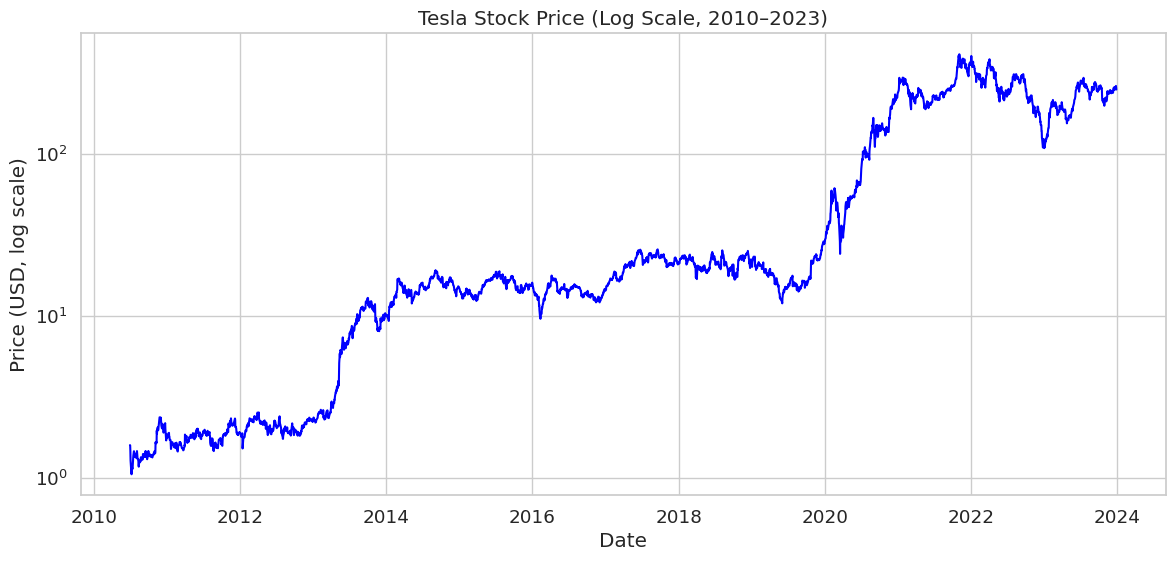

In [11]:
plt.figure(figsize=(14,6))
plt.plot(df.index, df["Close"], color="blue")
plt.yscale("log")
plt.title("Tesla Stock Price (Log Scale, 2010–2023)")
plt.xlabel("Date")
plt.ylabel("Price (USD, log scale)")
plt.show()


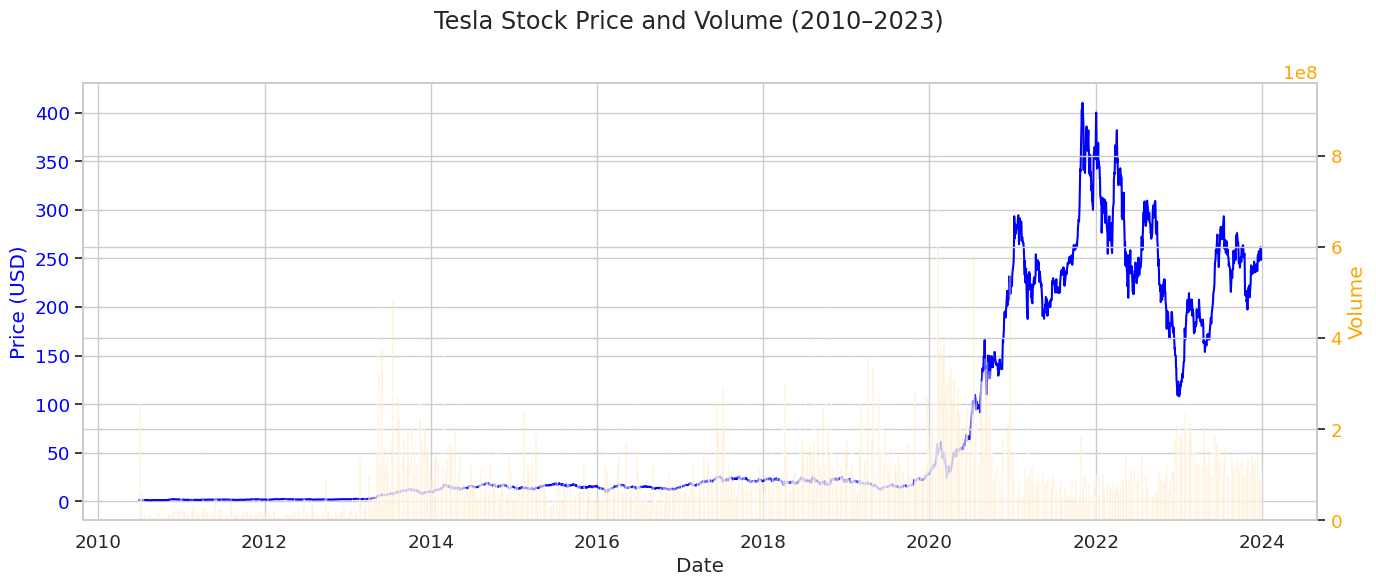

In [12]:
fig, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(df.index, df["Close"], color="blue", label="Close Price")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price (USD)", color="blue")
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.bar(df.index, df["Volume"], color="orange", alpha=0.3, label="Volume")
ax2.set_ylabel("Volume", color="orange")
ax2.tick_params(axis='y', labelcolor='orange')

fig.suptitle("Tesla Stock Price and Volume (2010–2023)")
fig.tight_layout()
plt.show()


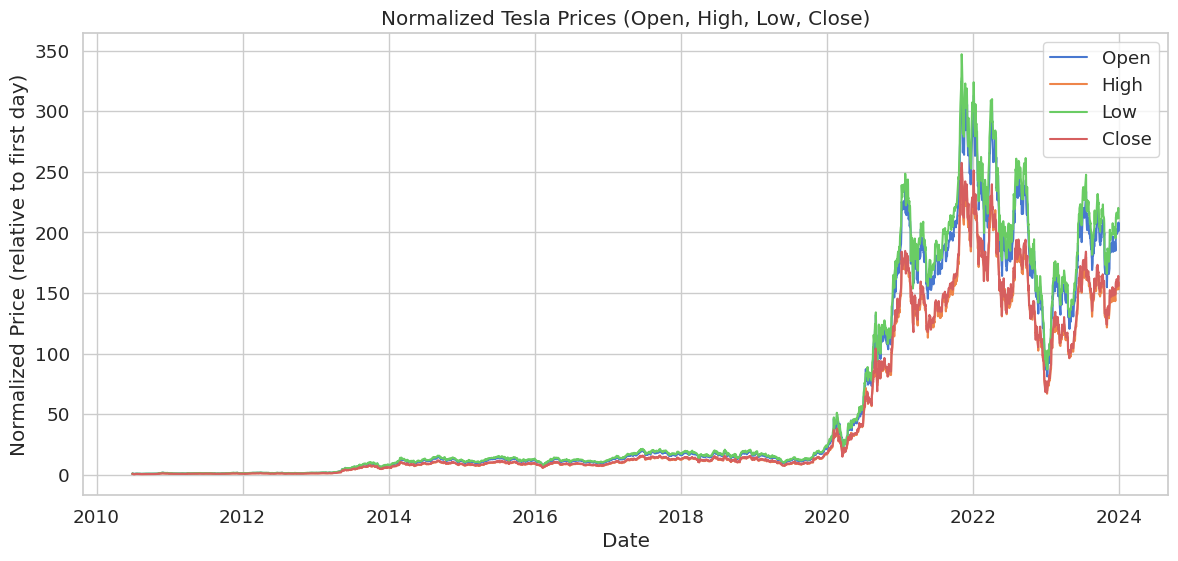

In [13]:
price_cols = ["Open", "High", "Low", "Close"]
df_norm = df[price_cols] / df[price_cols].iloc[0]

plt.figure(figsize=(14,6))
for col in price_cols:
    plt.plot(df_norm.index, df_norm[col], label=col)
plt.title("Normalized Tesla Prices (Open, High, Low, Close)")
plt.xlabel("Date")
plt.ylabel("Normalized Price (relative to first day)")
plt.legend()
plt.show()

In [10]:
df = pd.read_csv("tesla_stock_data.csv", parse_dates=["Date"])

df_clean = df.drop(index=0).reset_index(drop=True)

numeric_cols = ["Close", "High", "Low", "Open", "Volume"]
df_clean[numeric_cols] = df_clean[numeric_cols].apply(pd.to_numeric, errors='coerce')

df_clean = df_clean.dropna().reset_index(drop=True)

df_clean.to_csv("tesla_stock_cleaned.csv", index=False)

print("First invalid row dropped and cleaned CSV saved as 'tesla_stock_cleaned.csv'")
print("Columns and dtypes after cleaning:")
print(df_clean.dtypes)

First invalid row dropped and cleaned CSV saved as 'tesla_stock_cleaned.csv'
Columns and dtypes after cleaning:
Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object


In [15]:
dat = pd.read_csv("/content/tesla_stock_cleaned.csv")
dat

,Date,Close,High,Low,Open,Volume
0,2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
1,2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2,2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
3,2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
4,2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500
...,...,...,...,...,...,...
3395,2023-12-22,252.539993,258.220001,251.369995,256.760010,93370100
3396,2023-12-26,256.609985,257.970001,252.910004,254.490005,86892400
3397,2023-12-27,261.440002,263.339996,257.519989,258.350006,106494400
3398,2023-12-28,253.179993,265.130005,252.710007,263.660004,113619900


# Arima model

## Loading Data

In [47]:
import seaborn as sns
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

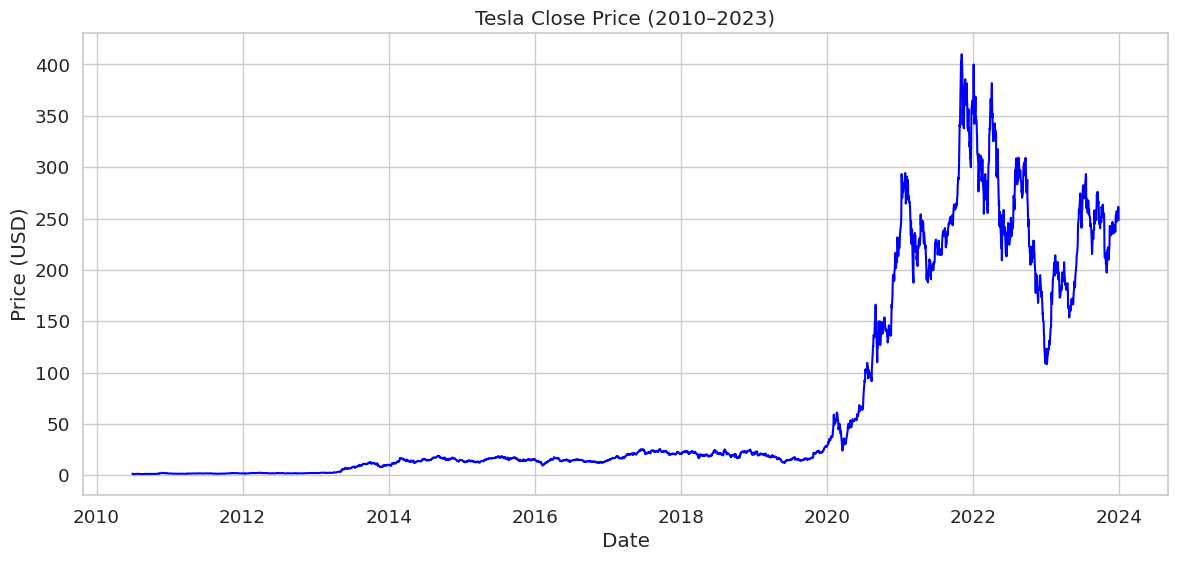

In [48]:
df = pd.read_csv("/content/tesla_stock_cleaned.csv", parse_dates=["Date"], index_col="Date")
ts = df["Close"]
plt.figure(figsize=(14,6))
plt.plot(ts, color="blue")
plt.title("Tesla Close Price (2010–2023)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()


## Step 2: Check for stationarity

In [49]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("Series is non-stationary. Differencing is required.")
else:
    print("Series is stationary. Ready for ARIMA.")


ADF Statistic: -0.8945070855884591
p-value: 0.7897759306181461
Series is non-stationary. Differencing is required.


## Step 3: Differencing the series

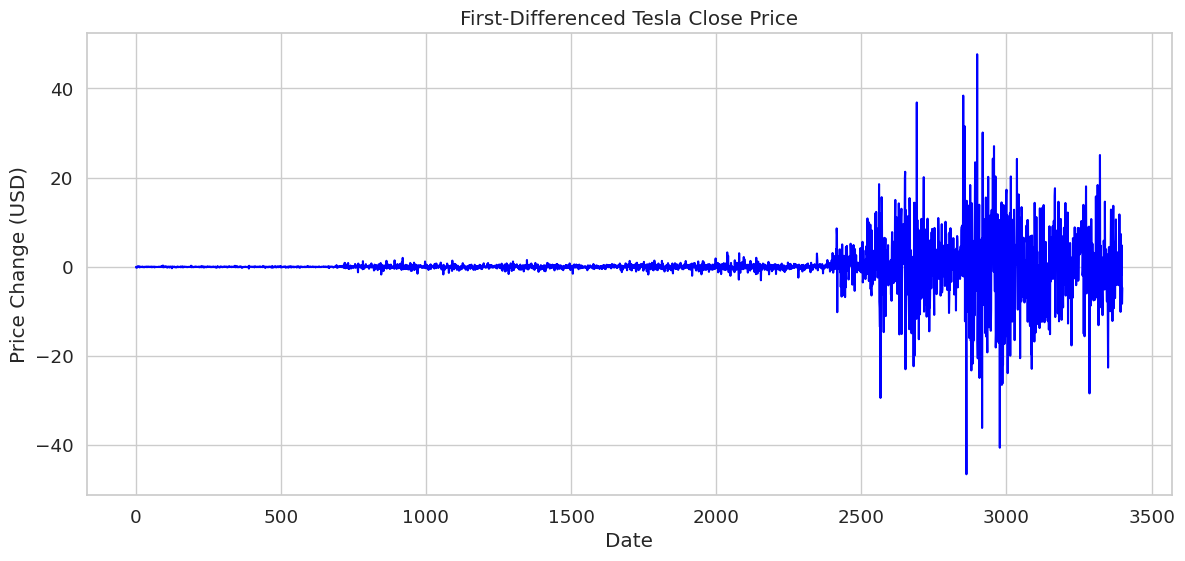

In [50]:
ts_diff = df_clean["Close"].diff().dropna()

import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
plt.plot(ts_diff, color="blue")
plt.title("First-Differenced Tesla Close Price")
plt.xlabel("Date")
plt.ylabel("Price Change (USD)")
plt.show()

##Step 4: Check ACF and PACF for ARIMA parameters

<Figure size 1200x400 with 0 Axes>

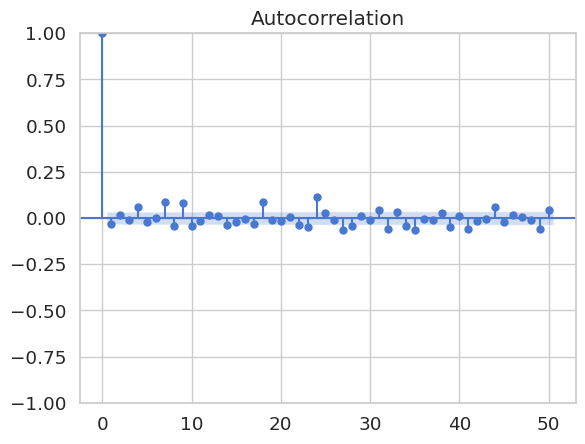

<Figure size 1200x400 with 0 Axes>

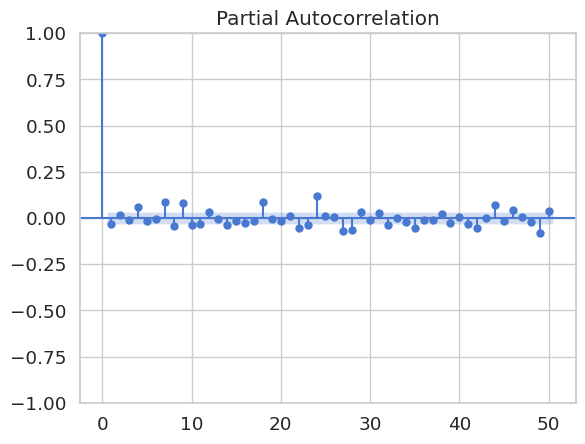

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,4))
plot_acf(ts_diff, lags=50)
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(ts_diff, lags=50)
plt.show()


##Step 5: Split data into train/test

In [52]:
train_size = int(len(df_clean) * 0.8)
train, test = df_clean["Close"][:train_size], df_clean["Close"][train_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")


Train size: 2720, Test size: 680


## Step 6: Fit ARIMA model

In [53]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(5,1,2))  # (p,d,q)
model_fit = model.fit()

print(model_fit.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2720
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -6197.448
Date:                Fri, 03 Oct 2025   AIC                          12410.895
Time:                        15:33:32   BIC                          12458.160
Sample:                             0   HQIC                         12427.982
                               - 2720                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3794      0.063     -6.020      0.000      -0.503      -0.256
ar.L2          0.0234      0.050      0.464      0.642      -0.075       0.122
ar.L3          0.0764      0.006     12.061      0.0

## STEP 7: Result Visualization

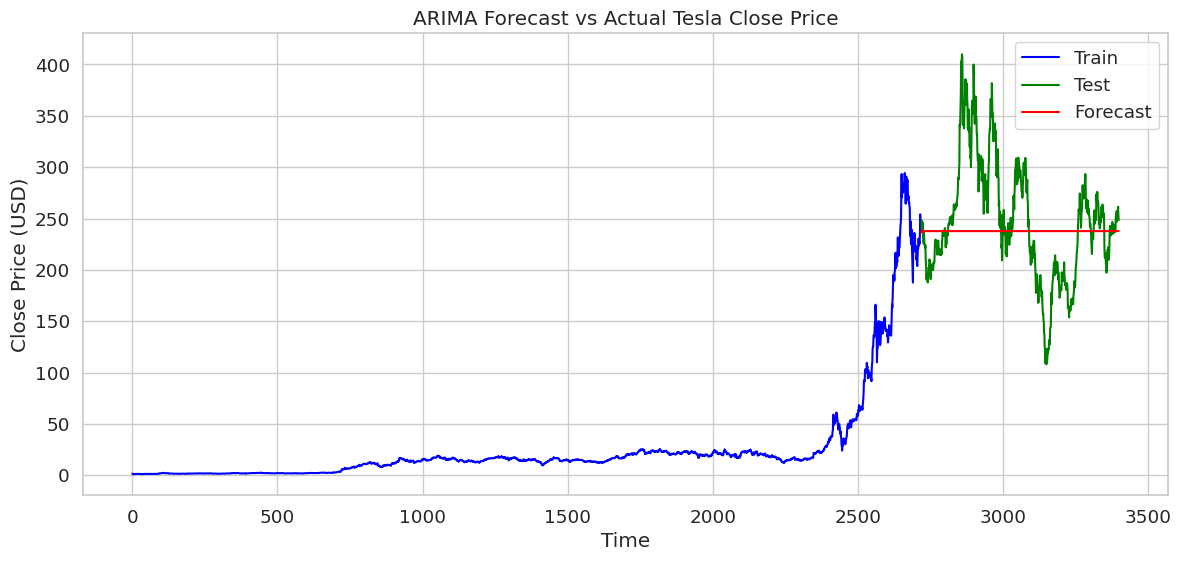

RMSE: 58.40
MAE : 44.74


In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

forecast = model_fit.forecast(steps=len(test))

plt.figure(figsize=(14,6))
plt.plot(train.index, train, label="Train", color="blue")
plt.plot(test.index, test, label="Test", color="green")
plt.plot(test.index, forecast, label="Forecast", color="red")
plt.title("ARIMA Forecast vs Actual Tesla Close Price")
plt.xlabel("Time")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)

print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")


## Saving Results

In [48]:
import pandas as pd
from sklearn.metrics import r2_score

In [49]:
# --- Evaluation Metrics ---
rmse = np.sqrt(mean_squared_error(test, forecast))
mae  = mean_absolute_error(test, forecast)
mape = np.mean(np.abs((test - forecast)/test)) * 100
r2   = r2_score(test, forecast)
smape = 100/len(test) * np.sum(2 * np.abs(forecast - test)/(np.abs(forecast) + np.abs(test)))

print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"R2   : {r2:.4f}")
print(f"SMAPE: {smape:.2f}%")


RMSE : 58.40
MAE  : 44.74
MAPE : 19.12%
R2   : -0.0242
SMAPE: 18.36%


In [50]:
# --- Saving ARIMA metrics to result.csv ---
metrics_arima = {
    "Model": "ARIMA",
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "SMAPE": smape
}

df_metrics = pd.DataFrame([metrics_arima])
df_metrics.to_csv("result.csv", index=False)
print("ARIMA metrics saved to result.csv")


ARIMA metrics saved to result.csv


In [51]:
import joblib
joblib.dump(model_fit, "arima_tesla_model.pkl")
print("Model saved as arima_tesla_model.pkl")

Model saved as arima_tesla_model.pkl


# Rolling Window Evaluation

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: Conver

Rolling-window ARIMA RMSE: 9.42
Rolling-window ARIMA MAE : 6.75


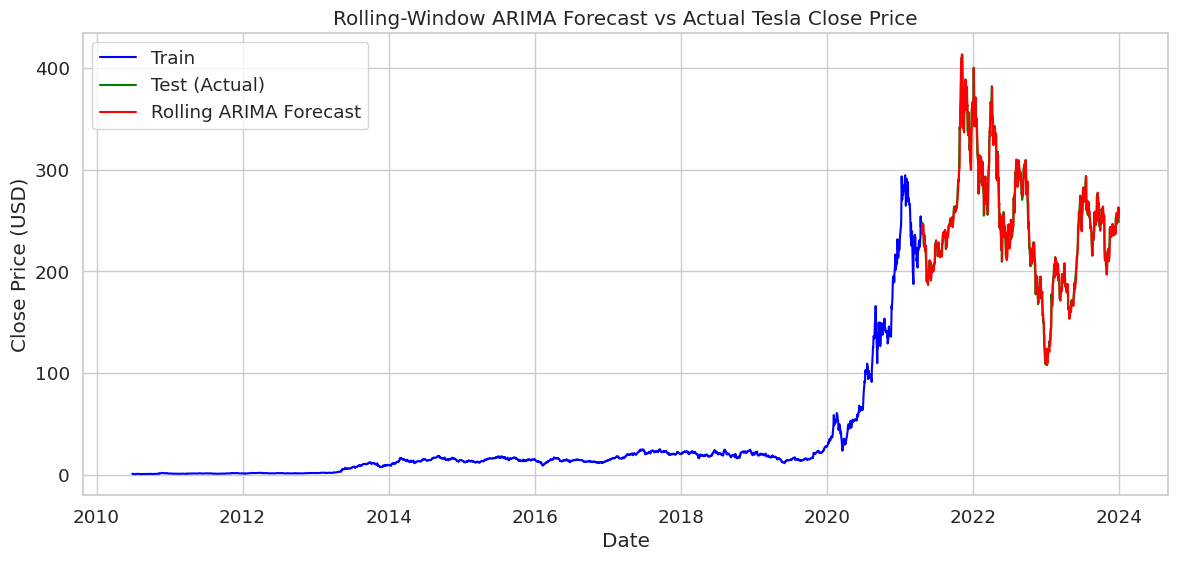

In [55]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

df = pd.read_csv("/content/tesla_stock_cleaned.csv", parse_dates=["Date"], index_col="Date")
ts = df["Close"]

train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

history = train.tolist()
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,2))
    model_fit = model.fit()

    yhat = model_fit.forecast()[0]
    predictions.append(yhat)

    history.append(test.iloc[t])

y_true = test.values
y_pred = np.array(predictions)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"Rolling-window ARIMA RMSE: {rmse:.2f}")
print(f"Rolling-window ARIMA MAE : {mae:.2f}")

plt.figure(figsize=(14,6))
plt.plot(train.index, train, label="Train", color="blue")
plt.plot(test.index, y_true, label="Test (Actual)", color="green")
plt.plot(test.index, y_pred, label="Rolling ARIMA Forecast", color="red")
plt.title("Rolling-Window ARIMA Forecast vs Actual Tesla Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()


## Rolling Window Evaluation

In [56]:
import numpy as np
from sklearn.metrics import r2_score

rmse = np.sqrt(np.mean((y_true - y_pred)**2))
mae  = np.mean(np.abs(y_true - y_pred))
r2   = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
smape = 100*np.mean(2*np.abs(y_pred - y_true)/(np.abs(y_pred)+np.abs(y_true)))

print(f"Rolling-window ARIMA RMSE : {rmse:.2f}")
print(f"Rolling-window ARIMA MAE  : {mae:.2f}")
print(f"Rolling-window ARIMA R2   : {r2:.4f}")
print(f"Rolling-window ARIMA MAPE : {mape:.2f}%")
print(f"Rolling-window ARIMA SMAPE: {smape:.2f}%")


Rolling-window ARIMA RMSE : 9.42
Rolling-window ARIMA MAE  : 6.75
Rolling-window ARIMA R2   : 0.9733
Rolling-window ARIMA MAPE : 2.74%
Rolling-window ARIMA SMAPE: 2.73%


# LSTM Model

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [37]:
# Reproducibility seeds
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)


# Step 1: Load cleaned CSV (saved earlier as tesla_stock_cleaned.csv)
csv_path = "tesla_stock_cleaned.csv"
df = pd.read_csv(csv_path, parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

numeric_cols = ["Close", "Open", "High", "Low", "Volume"]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna().reset_index(drop=True)

df.set_index("Date", inplace=True)

print("Loaded data shape:", df.shape)
print(df.head())


Loaded data shape: (3400, 5)
               Close      High       Low      Open     Volume
Date                                                         
2010-06-29  1.592667  1.666667  1.169333  1.266667  281494500
2010-06-30  1.588667  2.028000  1.553333  1.719333  257806500
2010-07-01  1.464000  1.728000  1.351333  1.666667  123282000
2010-07-02  1.280000  1.540000  1.247333  1.533333   77097000
2010-07-06  1.074000  1.333333  1.055333  1.333333  103003500


In [38]:

# Step 2: Define target series and train/test split parameters
series = df["Close"].values.reshape(-1, 1)   # univariate

train_ratio = 0.80
n_total = len(series)
train_size = int(n_total * train_ratio)
print(f"Total rows: {n_total}, Train_size: {train_size}, Test_size: {n_total - train_size}")


Total rows: 3400, Train_size: 2720, Test_size: 680


In [39]:
# Step 3: Scale data (MinMax) -- fit scaler ONLY on training portion
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(series[:train_size])

series_scaled = scaler.transform(series)

joblib.dump(scaler, "lstm_scaler.pkl")
print("Scaler saved to lstm_scaler.pkl")

Scaler saved to lstm_scaler.pkl


In [40]:
# Step 4: Create sequences (X) and labels (y)
def create_sequences(scaled_series, lookback=60):
    X, y = [], []
    N = len(scaled_series)
    for i in range(lookback, N):
        X.append(scaled_series[i - lookback:i, 0])
        y.append(scaled_series[i, 0])
    X = np.array(X)
    y = np.array(y)
    return X, y

lookback = 60
X_all, y_all = create_sequences(series_scaled, lookback=lookback)
print("All sequences shape (samples, lookback):", X_all.shape, y_all.shape)


All sequences shape (samples, lookback): (3340, 60) (3340,)


X_train shape: (2660, 60, 1)
y_train shape: (2660,)
X_test shape : (680, 60, 1)
y_test shape : (680,)


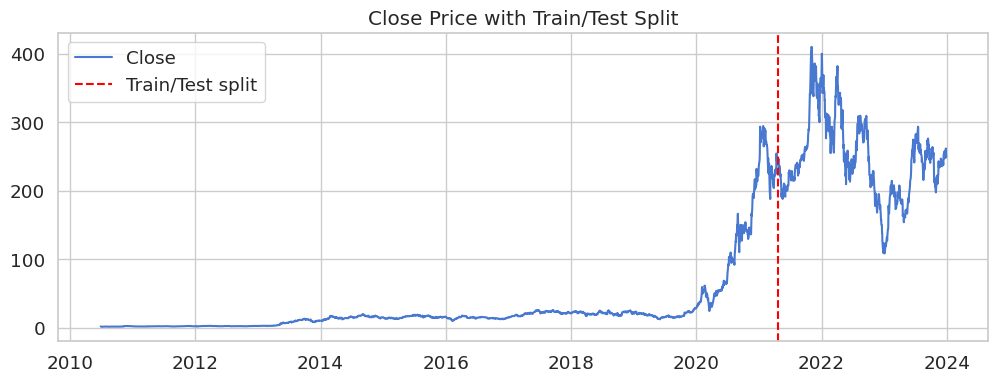

In [41]:
# Step 5: Split sequences into train/test by index
train_split_idx = train_size - lookback
if train_split_idx <= 0:
    raise ValueError("lookback too large for the chosen train split; reduce lookback or increase train_ratio")

X_train = X_all[:train_split_idx]
y_train = y_all[:train_split_idx]
X_test = X_all[train_split_idx:]
y_test = y_all[train_split_idx:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(df.index, df["Close"], label="Close")
plt.axvline(df.index[train_size], color="red", linestyle="--", label="Train/Test split")
plt.legend()
plt.title("Close Price with Train/Test Split")
plt.show()


In [42]:
# Step 6: Build a simple LSTM model (univariate)
model = Sequential([
    LSTM(64, input_shape=(lookback, 1), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Step 7: Train the model
callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_lstm_tesla.h5", monitor="val_loss", save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

model.save("lstm_tesla_final.h5")
print("Model saved to lstm_tesla_final.h5 and best_lstm_tesla.h5")


Epoch 1/100

Epoch 1: val_loss improved from inf to 0.00396, saving model to best_lstm_tesla.h5


84/84 - 5s - 55ms/step - loss: 0.0028 - mae: 0.0236 - val_loss: 0.0040 - val_mae: 0.0466
Epoch 2/100

Epoch 2: val_loss did not improve from 0.00396
84/84 - 2s - 25ms/step - loss: 6.1171e-04 - mae: 0.0113 - val_loss: 0.0054 - val_mae: 0.0594
Epoch 3/100

Epoch 3: val_loss did not improve from 0.00396
84/84 - 3s - 32ms/step - loss: 5.4585e-04 - mae: 0.0100 - val_loss: 0.0049 - val_mae: 0.0537
Epoch 4/100

Epoch 4: val_loss did not improve from 0.00396
84/84 - 3s - 34ms/step - loss: 6.7852e-04 - mae: 0.0131 - val_loss: 0.0053 - val_mae: 0.0570
Epoch 5/100

Epoch 5: val_loss did not improve from 0.00396
84/84 - 4s - 51ms/step - loss: 4.5069e-04 - mae: 0.0091 - val_loss: 0.0056 - val_mae: 0.0584
Epoch 6/100

Epoch 6: val_loss did not improve from 0.00396
84/84 - 3s - 31ms/step - loss: 4.3400e-04 - mae: 0.0099 - val_loss: 0.0047 - val_mae: 0.0527
Epoch 7/100

Epoch 7: val_loss did not improve from 0.00396
84/84 - 2s - 24ms/step - loss: 4.3649e-04 - mae: 0.0088 - val_loss: 0.0086 - val_mae: 

84/84 - 3s - 39ms/step - loss: 4.9439e-04 - mae: 0.0099 - val_loss: 0.0026 - val_mae: 0.0382
Epoch 9/100

Epoch 9: val_loss did not improve from 0.00265
84/84 - 2s - 29ms/step - loss: 3.3686e-04 - mae: 0.0078 - val_loss: 0.0037 - val_mae: 0.0463
Epoch 10/100

Epoch 10: val_loss did not improve from 0.00265
84/84 - 2s - 25ms/step - loss: 3.5215e-04 - mae: 0.0084 - val_loss: 0.0026 - val_mae: 0.0380
Epoch 11/100

Epoch 11: val_loss did not improve from 0.00265
84/84 - 2s - 24ms/step - loss: 4.1899e-04 - mae: 0.0093 - val_loss: 0.0062 - val_mae: 0.0644
Epoch 12/100

Epoch 12: val_loss did not improve from 0.00265
84/84 - 2s - 24ms/step - loss: 3.5182e-04 - mae: 0.0086 - val_loss: 0.0042 - val_mae: 0.0512
Epoch 13/100

Epoch 13: val_loss improved from 0.00265 to 0.00220, saving model to best_lstm_tesla.h5


84/84 - 3s - 33ms/step - loss: 3.6207e-04 - mae: 0.0094 - val_loss: 0.0022 - val_mae: 0.0346
Epoch 14/100

Epoch 14: val_loss did not improve from 0.00220
84/84 - 3s - 40ms/step - loss: 2.9380e-04 - mae: 0.0074 - val_loss: 0.0033 - val_mae: 0.0438
Epoch 15/100

Epoch 15: val_loss did not improve from 0.00220
84/84 - 2s - 24ms/step - loss: 3.4075e-04 - mae: 0.0080 - val_loss: 0.0034 - val_mae: 0.0444
Epoch 16/100

Epoch 16: val_loss did not improve from 0.00220
84/84 - 2s - 24ms/step - loss: 4.3457e-04 - mae: 0.0101 - val_loss: 0.0072 - val_mae: 0.0717
Epoch 17/100

Epoch 17: val_loss did not improve from 0.00220
84/84 - 2s - 24ms/step - loss: 3.1180e-04 - mae: 0.0078 - val_loss: 0.0029 - val_mae: 0.0404
Epoch 18/100

Epoch 18: val_loss did not improve from 0.00220
84/84 - 3s - 31ms/step - loss: 2.6651e-04 - mae: 0.0070 - val_loss: 0.0044 - val_mae: 0.0534
Epoch 19/100

Epoch 19: val_loss did not improve from 0.00220
84/84 - 4s - 47ms/step - loss: 2.7963e-04 - mae: 0.0082 - val_loss: 0.

Model saved to lstm_tesla_final.h5 and best_lstm_tesla.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
LSTM Test RMSE: 13.7722
LSTM Test MAE : 10.1606


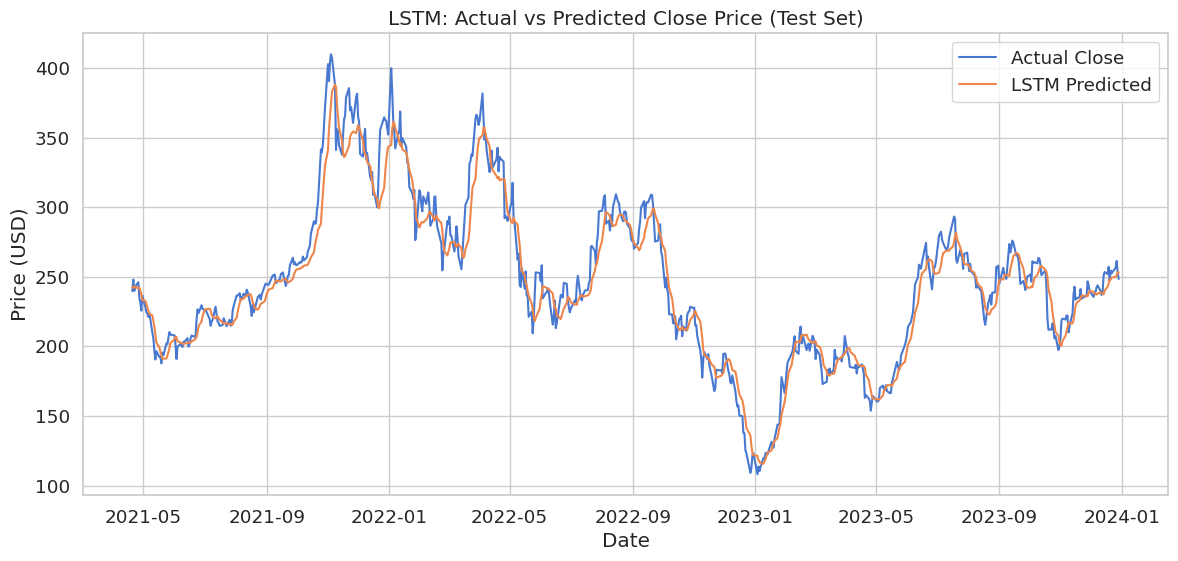

In [44]:

# Step 8: Evaluate on test set and compute RMSE/MAE in original price units
y_pred_scaled = model.predict(X_test).reshape(-1,1)
y_test_scaled = y_test.reshape(-1,1)

y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test_scaled)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
print(f"LSTM Test RMSE: {rmse:.4f}")
print(f"LSTM Test MAE : {mae:.4f}")

plt.figure(figsize=(14,6))
test_index = df.index[train_size + 0 : train_size + len(y_true)]  # careful index alignment
plt.plot(test_index, y_true, label="Actual Close")
plt.plot(test_index, y_pred, label="LSTM Predicted")
plt.title("LSTM: Actual vs Predicted Close Price (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

In [45]:

mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
r2   = r2_score(y_true, y_pred)
smape = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true)/(np.abs(y_pred) + np.abs(y_true)))

print(f"LSTM Test RMSE : {rmse:.2f}")
print(f"LSTM Test MAE  : {mae:.2f}")
print(f"LSTM Test MAPE : {mape:.2f}%")
print(f"LSTM Test R2   : {r2:.4f}")
print(f"LSTM Test SMAPE: {smape:.2f}%")


LSTM Test RMSE : 13.77
LSTM Test MAE  : 10.16
LSTM Test MAPE : 4.05%
LSTM Test R2   : 0.9430
LSTM Test SMAPE: 4.08%


In [62]:

metrics_lstm = {
    "Model": "LSTM (Close-only)",
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "SMAPE": smape
}

import os

csv_file = "result.csv"

if os.path.exists(csv_file):
    df_metrics = pd.read_csv(csv_file)
    df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_lstm])], ignore_index=True)
else:
    df_metrics = pd.DataFrame([metrics_lstm])

df_metrics.to_csv(csv_file, index=False)
print("LSTM metrics appended to result.csv")


LSTM metrics appended to result.csv


## Rolling Window Evaluation

Rolling Window RMSE : 68.1963
Rolling Window MAE  : 52.8509
Rolling Window MAPE : 20.47%
Rolling Window SMAPE: 21.97%
Rolling Window R2   : -0.3966


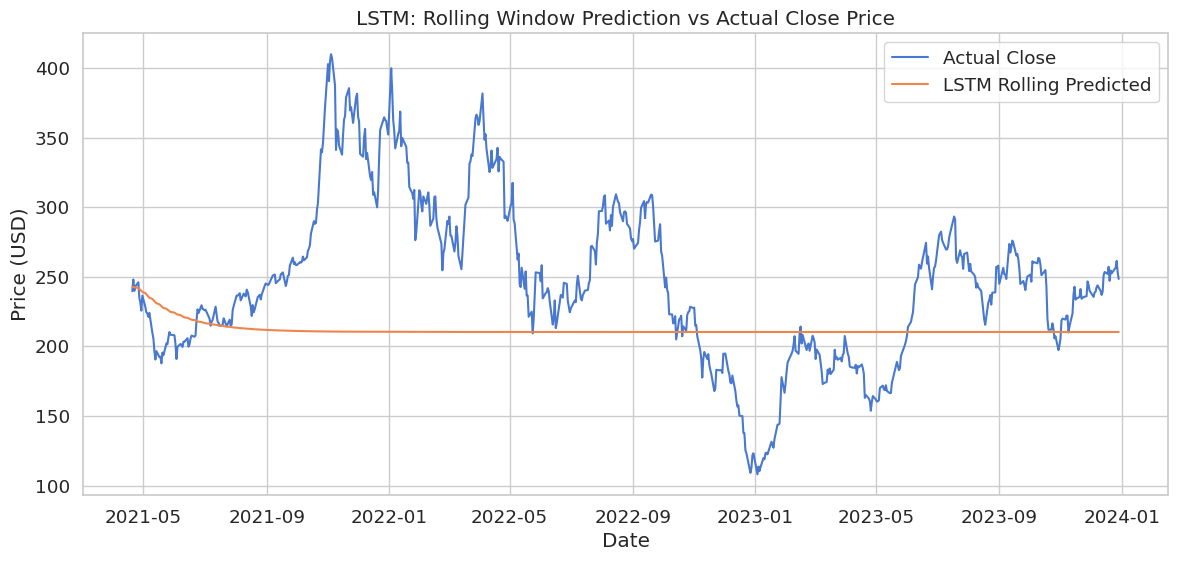

In [46]:

preds_rw = []
X_pred = X_test[0].reshape(1, lookback, 1)

for i in range(len(y_test)):
    pred_scaled = model.predict(X_pred, verbose=0)
    preds_rw.append(pred_scaled[0,0])

    X_pred = np.append(X_pred[:, 1:, :], pred_scaled.reshape(1,1,1), axis=1)

preds_rw = scaler.inverse_transform(np.array(preds_rw).reshape(-1,1)).flatten()
y_true_rw = scaler.inverse_transform(y_test_scaled).flatten()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse_rw = np.sqrt(mean_squared_error(y_true_rw, preds_rw))
mae_rw  = mean_absolute_error(y_true_rw, preds_rw)
mape_rw = np.mean(np.abs((y_true_rw - preds_rw)/y_true_rw))*100
smape_rw = 100/len(y_true_rw) * np.sum(2*np.abs(preds_rw - y_true_rw)/(np.abs(preds_rw)+np.abs(y_true_rw)))
r2_rw   = r2_score(y_true_rw, preds_rw)

print(f"Rolling Window RMSE : {rmse_rw:.4f}")
print(f"Rolling Window MAE  : {mae_rw:.4f}")
print(f"Rolling Window MAPE : {mape_rw:.2f}%")
print(f"Rolling Window SMAPE: {smape_rw:.2f}%")
print(f"Rolling Window R2   : {r2_rw:.4f}")

plt.figure(figsize=(14,6))
plt.plot(test_index, y_true_rw, label="Actual Close")
plt.plot(test_index, preds_rw, label="LSTM Rolling Predicted")
plt.title("LSTM: Rolling Window Prediction vs Actual Close Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


# Multivariate LSTM pipeline for Tesla stock (Open, High, Low, Close, Volume)

               Close      High       Low      Open     Volume
Date                                                         
2010-06-29  1.592667  1.666667  1.169333  1.266667  281494500
2010-06-30  1.588667  2.028000  1.553333  1.719333  257806500
2010-07-01  1.464000  1.728000  1.351333  1.666667  123282000
2010-07-02  1.280000  1.540000  1.247333  1.533333   77097000
2010-07-06  1.074000  1.333333  1.055333  1.333333  103003500
Scaler saved.
X_all shape: (3340, 60, 5) y_all shape: (3340,)
X_train shape: (2660, 60, 5)
X_test shape : (680, 60, 5)
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00751, saving model to best_multivariate_lstm.h5


84/84 - 5s - 54ms/step - loss: 0.0014 - mae: 0.0167 - val_loss: 0.0075 - val_mae: 0.0676
Epoch 2/100

Epoch 2: val_loss improved from 0.00751 to 0.00375, saving model to best_multivariate_lstm.h5


84/84 - 2s - 28ms/step - loss: 5.4293e-04 - mae: 0.0114 - val_loss: 0.0038 - val_mae: 0.0444
Epoch 3/100

Epoch 3: val_loss did not improve from 0.00375
84/84 - 3s - 38ms/step - loss: 5.3278e-04 - mae: 0.0107 - val_loss: 0.0087 - val_mae: 0.0761
Epoch 4/100

Epoch 4: val_loss did not improve from 0.00375
84/84 - 4s - 47ms/step - loss: 7.9244e-04 - mae: 0.0145 - val_loss: 0.0083 - val_mae: 0.0736
Epoch 5/100

Epoch 5: val_loss did not improve from 0.00375
84/84 - 2s - 24ms/step - loss: 4.5885e-04 - mae: 0.0106 - val_loss: 0.0059 - val_mae: 0.0602
Epoch 6/100

Epoch 6: val_loss did not improve from 0.00375
84/84 - 2s - 24ms/step - loss: 5.1454e-04 - mae: 0.0105 - val_loss: 0.0091 - val_mae: 0.0797
Epoch 7/100

Epoch 7: val_loss did not improve from 0.00375
84/84 - 4s - 52ms/step - loss: 4.3231e-04 - mae: 0.0093 - val_loss: 0.0059 - val_mae: 0.0607
Epoch 8/100

Epoch 8: val_loss improved from 0.00375 to 0.00323, saving model to best_multivariate_lstm.h5


84/84 - 3s - 42ms/step - loss: 3.5659e-04 - mae: 0.0079 - val_loss: 0.0032 - val_mae: 0.0419
Epoch 9/100

Epoch 9: val_loss did not improve from 0.00323
84/84 - 2s - 24ms/step - loss: 3.7228e-04 - mae: 0.0087 - val_loss: 0.0056 - val_mae: 0.0593
Epoch 10/100

Epoch 10: val_loss improved from 0.00323 to 0.00225, saving model to best_multivariate_lstm.h5


84/84 - 2s - 26ms/step - loss: 3.5134e-04 - mae: 0.0074 - val_loss: 0.0022 - val_mae: 0.0348
Epoch 11/100

Epoch 11: val_loss did not improve from 0.00225
84/84 - 2s - 28ms/step - loss: 4.6625e-04 - mae: 0.0106 - val_loss: 0.0026 - val_mae: 0.0379
Epoch 12/100

Epoch 12: val_loss did not improve from 0.00225
84/84 - 2s - 24ms/step - loss: 5.3983e-04 - mae: 0.0117 - val_loss: 0.0055 - val_mae: 0.0595
Epoch 13/100

Epoch 13: val_loss did not improve from 0.00225
84/84 - 3s - 31ms/step - loss: 3.4864e-04 - mae: 0.0084 - val_loss: 0.0031 - val_mae: 0.0419
Epoch 14/100

Epoch 14: val_loss did not improve from 0.00225
84/84 - 5s - 55ms/step - loss: 3.1039e-04 - mae: 0.0071 - val_loss: 0.0036 - val_mae: 0.0453
Epoch 15/100

Epoch 15: val_loss did not improve from 0.00225
84/84 - 2s - 29ms/step - loss: 3.8748e-04 - mae: 0.0086 - val_loss: 0.0057 - val_mae: 0.0603
Epoch 16/100

Epoch 16: val_loss did not improve from 0.00225
84/84 - 2s - 30ms/step - loss: 4.2270e-04 - mae: 0.0096 - val_loss: 0.

Model saved.
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Multivariate LSTM Test RMSE: 13.9107
Multivariate LSTM Test MAE : 10.1978


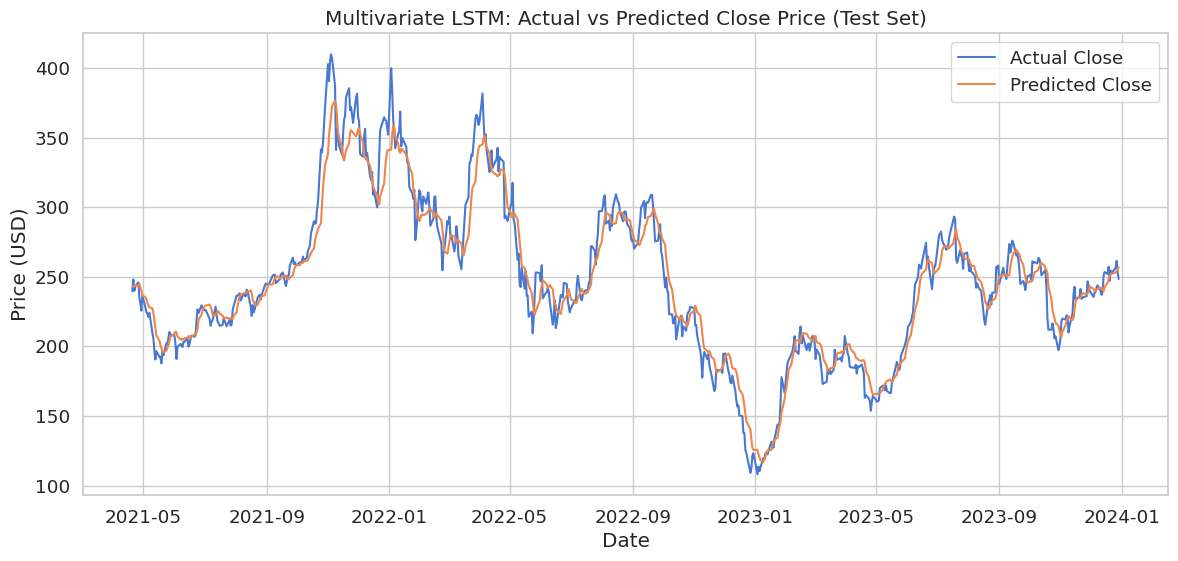

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os, random


seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Step 1: Load cleaned CSV
df = pd.read_csv("tesla_stock_cleaned.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna().reset_index(drop=True)

df.set_index("Date", inplace=True)
print(df.head())

# Step 2: Define target (Close) and input features (all columns)
features = ["Open", "High", "Low", "Close", "Volume"]
target = "Close"

series = df[features].values

train_ratio = 0.8
train_size = int(len(series) * train_ratio)

# Step 3: Scale features (fit scaler only on train)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(series[:train_size])
series_scaled = scaler.transform(series)

joblib.dump(scaler, "multivariate_lstm_scaler.pkl")
print("Scaler saved.")


# Step 4: Create sequences
lookback = 60
def create_sequences_multivariate(data, lookback=60):
    X, y = [], []
    N = len(data)
    for i in range(lookback, N):
        X.append(data[i - lookback:i, :])
        y.append(data[i, 3])
    return np.array(X), np.array(y)

X_all, y_all = create_sequences_multivariate(series_scaled, lookback)
print("X_all shape:", X_all.shape, "y_all shape:", y_all.shape)

# Step 5: Train/test split
train_split_idx = train_size - lookback
X_train, y_train = X_all[:train_split_idx], y_all[:train_split_idx]
X_test, y_test   = X_all[train_split_idx:], y_all[train_split_idx:]

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)

# Step 6: Build multivariate LSTM
model = Sequential([
    LSTM(64, input_shape=(lookback, len(features)), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)  # predict Close price
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Step 7: Train the model
callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_multivariate_lstm.h5", monitor="val_loss", save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

# Save final model (optional)
model.save("multivariate_lstm_final.h5")
print("Model saved.")

# Step 8: Evaluate
y_pred_scaled = model.predict(X_test).reshape(-1,1)
y_test_scaled  = y_test.reshape(-1,1)

y_pred = scaler.inverse_transform(np.concatenate(
    [np.zeros((len(y_pred_scaled), 3)), y_pred_scaled, np.zeros((len(y_pred_scaled),1))], axis=1
))[:,3]  # extract Close

y_true = scaler.inverse_transform(np.concatenate(
    [np.zeros((len(y_test_scaled), 3)), y_test_scaled, np.zeros((len(y_test_scaled),1))], axis=1
))[:,3]

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
print(f"Multivariate LSTM Test RMSE: {rmse:.4f}")
print(f"Multivariate LSTM Test MAE : {mae:.4f}")


# Step 9: Plot
plt.figure(figsize=(14,6))
test_index = df.index[train_size + 0 : train_size + len(y_true)]
plt.plot(test_index, y_true, label="Actual Close")
plt.plot(test_index, y_pred, label="Predicted Close")
plt.title("Multivariate LSTM: Actual vs Predicted Close Price (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [64]:
# --- Compute additional metrics ---
from sklearn.metrics import r2_score

mape  = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
r2    = r2_score(y_true, y_pred)
smape = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true)/(np.abs(y_pred) + np.abs(y_true)))

print(f"Multivariate LSTM Test MAPE : {mape:.2f}%")
print(f"Multivariate LSTM Test R2   : {r2:.4f}")
print(f"Multivariate LSTM Test SMAPE: {smape:.2f}%")


Multivariate LSTM Test MAPE : 4.16%
Multivariate LSTM Test R2   : 0.9419
Multivariate LSTM Test SMAPE: 4.13%


In [65]:
# --- Append metrics to result.csv ---
metrics_multi_lstm = {
    "Model": "Multivariate LSTM",
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "SMAPE": smape
}

import os

csv_file = "result.csv"
if os.path.exists(csv_file):
    df_metrics = pd.read_csv(csv_file)
    df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_multi_lstm])], ignore_index=True)
else:
    df_metrics = pd.DataFrame([metrics_multi_lstm])

df_metrics.to_csv(csv_file, index=False)
print("Multivariate LSTM metrics appended to result.csv")


Multivariate LSTM metrics appended to result.csv


## Rolling Window Evaluation

/tmp/ipython-input-351469515.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[-1, 3] = pred_scaled      # replace Close with predicted


Rolling Window RMSE : 14.9777
Rolling Window MAE  : 11.0079
Rolling Window MAPE : 4.49%
Rolling Window SMAPE: 4.46%


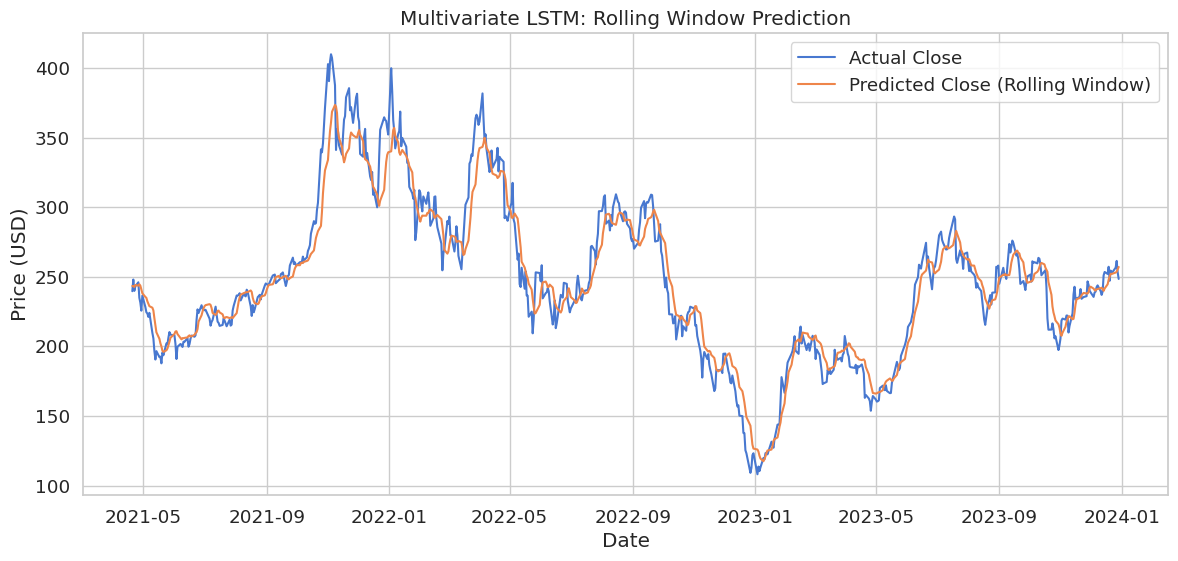

In [22]:

lookback = 60
X_test_rw = X_all[train_split_idx:]
y_test_rw = y_all[train_split_idx:]

preds_rw_scaled = []
X_rw = X_test_rw.copy()

for i in range(len(y_test_rw)):
    # predict next step
    pred_scaled = model.predict(X_rw[i:i+1], verbose=0)
    preds_rw_scaled.append(pred_scaled[0,0])

    if i + 1 < len(X_rw):
        new_row = X_rw[i+1].copy()
        new_row[-1, 3] = pred_scaled
        X_rw[i+1] = new_row

preds_rw = scaler.inverse_transform(
    np.concatenate(
        [np.zeros((len(preds_rw_scaled), 3)), np.array(preds_rw_scaled).reshape(-1,1), np.zeros((len(preds_rw_scaled),1))], axis=1
    )
)[:,3]


y_true_rw = scaler.inverse_transform(
    np.concatenate(
        [np.zeros((len(y_test_rw), 3)), y_test_rw.reshape(-1,1), np.zeros((len(y_test_rw),1))], axis=1
    )
)[:,3]

rmse_rw = np.sqrt(mean_squared_error(y_true_rw, preds_rw))
mae_rw  = mean_absolute_error(y_true_rw, preds_rw)
mape_rw = np.mean(np.abs((y_true_rw - preds_rw)/y_true_rw)) * 100
smape_rw = 100/len(y_true_rw) * np.sum(2*np.abs(preds_rw - y_true_rw)/(np.abs(preds_rw)+np.abs(y_true_rw)))

print(f"Rolling Window RMSE : {rmse_rw:.4f}")
print(f"Rolling Window MAE  : {mae_rw:.4f}")
print(f"Rolling Window MAPE : {mape_rw:.2f}%")
print(f"Rolling Window SMAPE: {smape_rw:.2f}%")

plt.figure(figsize=(14,6))
test_index = df.index[train_size + 0 : train_size + len(y_true_rw)]
plt.plot(test_index, y_true_rw, label="Actual Close")
plt.plot(test_index, preds_rw, label="Predicted Close (Rolling Window)")
plt.title("Multivariate LSTM: Rolling Window Prediction")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [23]:
from sklearn.metrics import r2_score

r2_rw = r2_score(y_true_rw, preds_rw)
print(f"Rolling Window R2 : {r2_rw:.4f}")


Rolling Window R2 : 0.9326


# Prophet Model

          ds         y
0 2010-06-29  1.592667
1 2010-06-30  1.588667
2 2010-07-01  1.464000
3 2010-07-02  1.280000
4 2010-07-06  1.074000


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7pxgy_h8/lv1sswlp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7pxgy_h8/_obd2a3q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42436', 'data', 'file=/tmp/tmp7pxgy_h8/lv1sswlp.json', 'init=/tmp/tmp7pxgy_h8/_obd2a3q.json', 'output', 'file=/tmp/tmp7pxgy_h8/prophet_modelbe81b1vu/prophet_model-20251003140859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:08:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:09:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Test RMSE: 104.9647
Prophet Test MAE : 85.8856


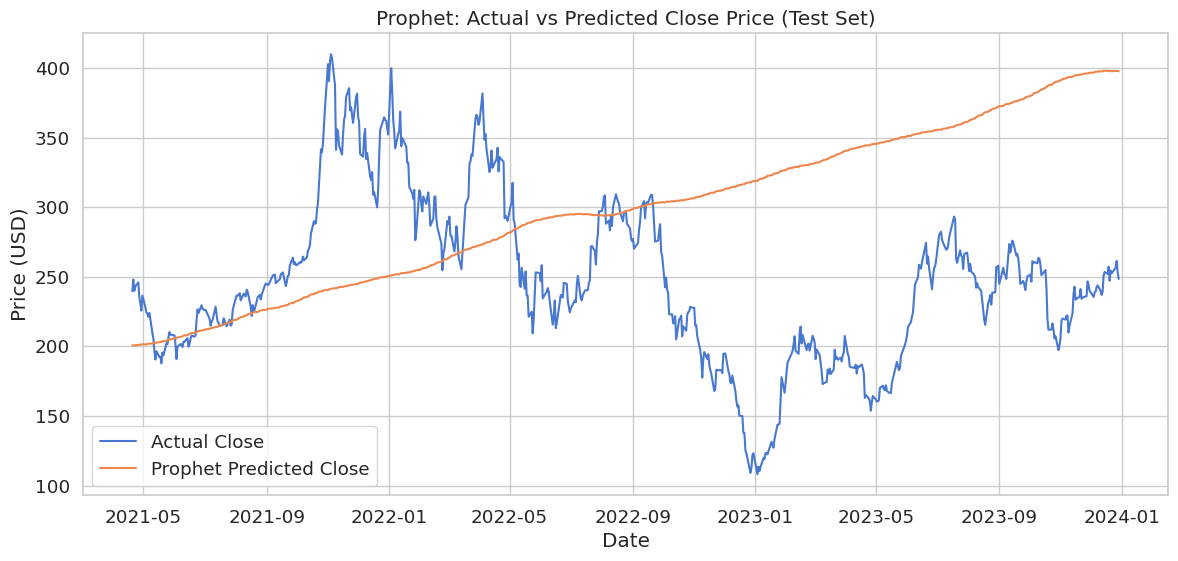

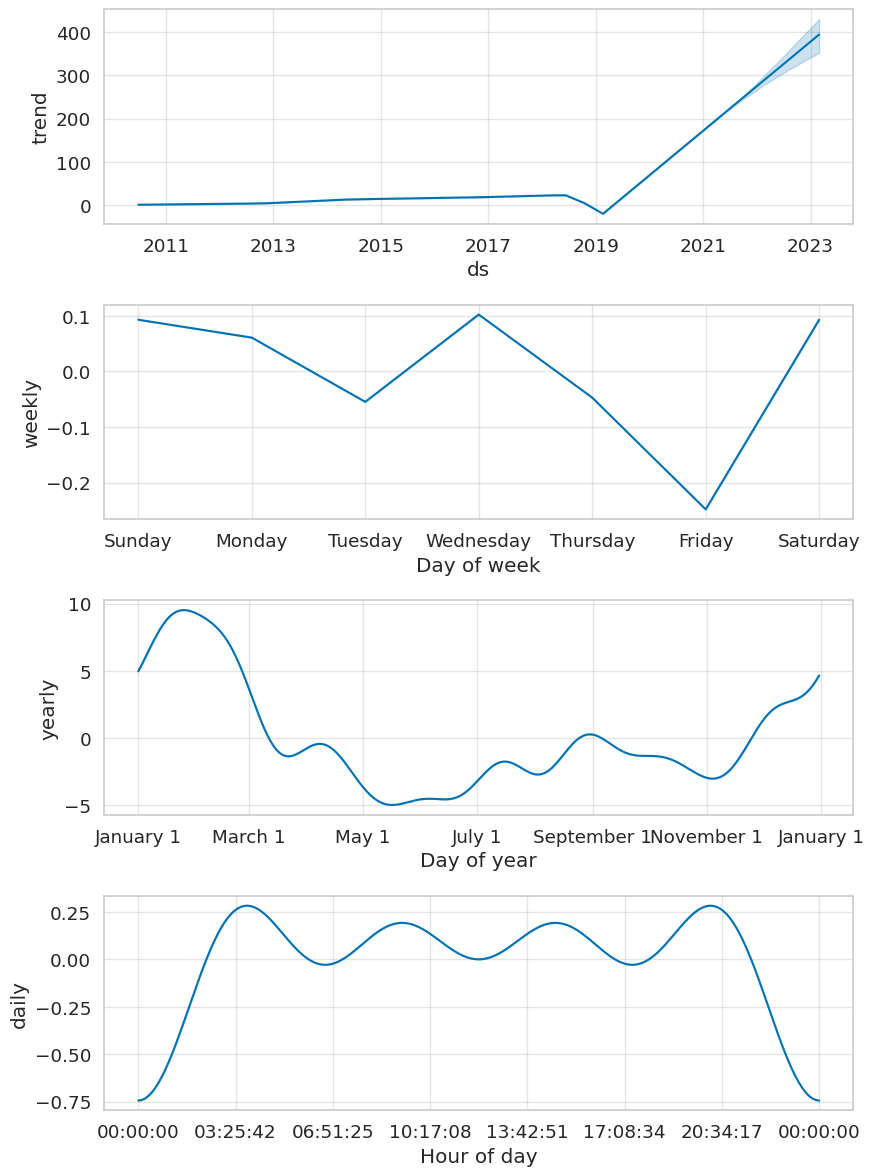

Prophet model saved as prophet_tesla_model.pkl


In [16]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# -----------------------
# Step 1: Load cleaned CSV
df = pd.read_csv("tesla_stock_cleaned.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df = df.dropna().reset_index(drop=True)

# -----------------------
# Step 2: Prepare DataFrame for Prophet
prophet_df = df[["Date", "Close"]].rename(columns={"Date": "ds", "Close": "y"})
print(prophet_df.head())

# -----------------------
# Step 3: Split into train/test
train_ratio = 0.8
train_size = int(len(prophet_df) * train_ratio)
train_df = prophet_df.iloc[:train_size]
test_df  = prophet_df.iloc[train_size:]

# -----------------------
# Step 4: Initialize and fit Prophet model
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(train_df)

# -----------------------
# Step 5: Make future dataframe (for test set)
future = model.make_future_dataframe(periods=len(test_df))
forecast = model.predict(future)

# -----------------------
# Step 6: Evaluate on test set
forecast_test = forecast.iloc[train_size:][["ds", "yhat"]].reset_index(drop=True)
y_true = test_df["y"].values
y_pred = forecast_test["yhat"].values
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
print(f"Prophet Test RMSE: {rmse:.4f}")
print(f"Prophet Test MAE : {mae:.4f}")

# -----------------------
# Step 7: Plot forecast vs actuals
plt.figure(figsize=(14,6))
plt.plot(test_df["ds"], y_true, label="Actual Close")
plt.plot(test_df["ds"], y_pred, label="Prophet Predicted Close")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Prophet: Actual vs Predicted Close Price (Test Set)")
plt.legend()
plt.show()

# -----------------------
# Step 8: Optional - Plot forecast components
model.plot_components(forecast)
plt.show()

# -----------------------
# Step 9: Save the model for deployment
import joblib
joblib.dump(model, "prophet_tesla_model.pkl")
print("Prophet model saved as prophet_tesla_model.pkl")


In [17]:
from sklearn.metrics import r2_score
mape  = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
r2    = r2_score(y_true, y_pred)
smape = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true)/(np.abs(y_pred) + np.abs(y_true)))

print(f"Prophet Test MAPE : {mape:.2f}%")
print(f"Prophet Test R2   : {r2:.4f}")
print(f"Prophet Test SMAPE: {smape:.2f}%")

Prophet Test MAPE : 40.19%
Prophet Test R2   : -2.3086
Prophet Test SMAPE: 31.17%


In [68]:
metrics_prophet = {
    "Model": "Prophet",
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "SMAPE": smape
}

import os
csv_file = "result.csv"

if os.path.exists(csv_file):
    df_metrics = pd.read_csv(csv_file)
    df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_prophet])], ignore_index=True)
else:
    df_metrics = pd.DataFrame([metrics_prophet])

df_metrics.to_csv(csv_file, index=False)
print("Prophet metrics appended to result.csv")


Prophet metrics appended to result.csv


## Rolling Window Evaluation

In [18]:
from prophet import Prophet
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_ratio = 0.8
train_size = int(len(prophet_df) * train_ratio)

train_df = prophet_df.iloc[:train_size].copy()
test_df  = prophet_df.iloc[train_size:].copy()

rolling_preds = []

for i in range(len(test_df)):
    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    model.fit(train_df)

    future = model.make_future_dataframe(periods=1)
    forecast = model.predict(future)

    pred = forecast.iloc[-1]["yhat"]
    rolling_preds.append(pred)
    next_row = test_df.iloc[i:i+1]
    train_df = pd.concat([train_df, next_row], ignore_index=True)

y_true = test_df["y"].values
y_pred = np.array(rolling_preds)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
smape = 100/len(y_true) * np.sum(2*np.abs(y_pred - y_true)/(np.abs(y_pred)+np.abs(y_true)))
r2 = r2_score(y_true, y_pred)

print(f"Rolling Prophet RMSE : {rmse:.4f}")
print(f"Rolling Prophet MAE  : {mae:.4f}")
print(f"Rolling Prophet MAPE : {mape:.2f}%")
print(f"Rolling Prophet SMAPE: {smape:.2f}%")
print(f"Rolling Prophet R2 : {r2:.4f}")

Streaming output truncated to the last 5000 lines.
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98567', 'data', 'file=/tmp/tmp7pxgy_h8/7z9qghvh.json', 'init=/tmp/tmp7pxgy_h8/eca7h3ea.json', 'output', 'file=/tmp/tmp7pxgy_h8/prophet_modelu415wmy9/prophet_model-20251003141258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:12:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:13:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7pxgy_h8/cmyalg8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7pxgy_h8/h4_rsl6d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53246', 'data', 'file=/tmp/tmp7pxgy_h8/cmyalg8h.json', 'init=/tm

Rolling Prophet RMSE : 78.9953
Rolling Prophet MAE  : 59.6115
Rolling Prophet MAPE : 29.04%
Rolling Prophet SMAPE: 22.63%
Rolling Prophet R2 : -0.8740


# GRU

Scaler saved as gru_scaler.pkl


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977 (58.50 KB)

 Trainable params: 14,977 (58.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.00179, saving model to best_gru_tesla.h5


84/84 - 8s - 97ms/step - loss: 0.0028 - mae: 0.0223 - val_loss: 0.0018 - val_mae: 0.0318
Epoch 2/100

Epoch 2: val_loss improved from 0.00179 to 0.00178, saving model to best_gru_tesla.h5


84/84 - 5s - 58ms/step - loss: 4.7088e-04 - mae: 0.0107 - val_loss: 0.0018 - val_mae: 0.0316
Epoch 3/100

Epoch 3: val_loss did not improve from 0.00178
84/84 - 6s - 68ms/step - loss: 3.7747e-04 - mae: 0.0091 - val_loss: 0.0035 - val_mae: 0.0476
Epoch 4/100

Epoch 4: val_loss did not improve from 0.00178
84/84 - 3s - 31ms/step - loss: 6.2076e-04 - mae: 0.0129 - val_loss: 0.0043 - val_mae: 0.0539
Epoch 5/100

Epoch 5: val_loss did not improve from 0.00178
84/84 - 3s - 31ms/step - loss: 4.1003e-04 - mae: 0.0092 - val_loss: 0.0045 - val_mae: 0.0554
Epoch 6/100

Epoch 6: val_loss did not improve from 0.00178
84/84 - 3s - 31ms/step - loss: 3.1654e-04 - mae: 0.0082 - val_loss: 0.0034 - val_mae: 0.0470
Epoch 7/100

Epoch 7: val_loss did not improve from 0.00178
84/84 - 5s - 64ms/step - loss: 3.5945e-04 - mae: 0.0093 - val_loss: 0.0058 - val_mae: 0.0660
Epoch 8/100

Epoch 8: val_loss did not improve from 0.00178
84/84 - 3s - 31ms/step - loss: 3.7398e-04 - mae: 0.0092 - val_loss: 0.0027 - val_m

Model saved as gru_tesla_final.h5 and best_gru_tesla.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
GRU Test RMSE : 12.3783
GRU Test MAE  : 9.2585
GRU Test MAPE : 3.75%
GRU Test R2   : 0.9540
GRU Test SMAPE: 3.75%


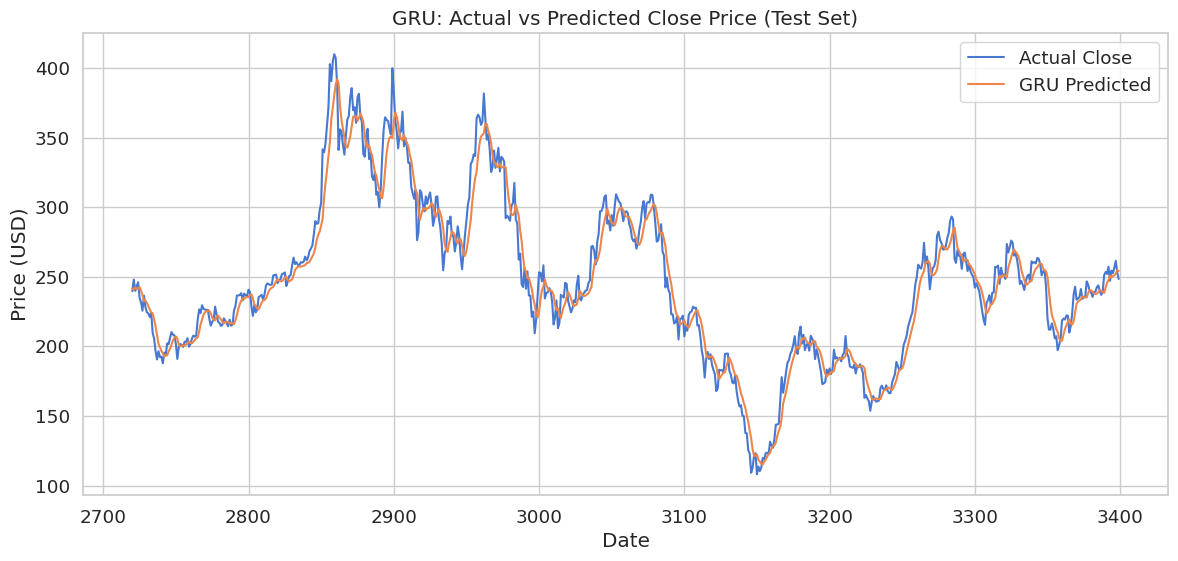

GRU metrics appended to result.csv


In [11]:

# GRU time-series forecasting for Tesla stock (Univariate: Close)

import numpy as np
import pandas as pd
import joblib
import os, random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Step 1: Load cleaned CSV
df = pd.read_csv("tesla_stock_cleaned.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df = df.dropna().reset_index(drop=True)

# Step 2: Define target series and train/test split
series = df["Close"].values.reshape(-1,1)
train_ratio = 0.8
train_size = int(len(series)*train_ratio)

# Step 3: Scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(series[:train_size])
series_scaled = scaler.transform(series)

joblib.dump(scaler, "gru_scaler.pkl")
print("Scaler saved as gru_scaler.pkl")

# Step 4: Create sequences
lookback = 60
def create_sequences(data, lookback=60):
    X, y = [], []
    N = len(data)
    for i in range(lookback, N):
        X.append(data[i-lookback:i,0])
        y.append(data[i,0])
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(series_scaled, lookback)
train_split_idx = train_size - lookback
X_train, y_train = X_all[:train_split_idx], y_all[:train_split_idx]
X_test, y_test   = X_all[train_split_idx:], y_all[train_split_idx:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1],1))

# Step 5: Build GRU model
model = Sequential([
    GRU(64, input_shape=(lookback,1), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

# Step 6: Train model
callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_gru_tesla.h5", monitor="val_loss", save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

model.save("gru_tesla_final.h5")
print("Model saved as gru_tesla_final.h5 and best_gru_tesla.h5")

# Step 7: Evaluate
y_pred_scaled = model.predict(X_test).reshape(-1,1)
y_test_scaled  = y_test.reshape(-1,1)

y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test_scaled)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
r2   = r2_score(y_true, y_pred)
smape = 100/len(y_true) * np.sum(2*np.abs(y_pred - y_true)/(np.abs(y_pred)+np.abs(y_true)))

print(f"GRU Test RMSE : {rmse:.4f}")
print(f"GRU Test MAE  : {mae:.4f}")
print(f"GRU Test MAPE : {mape:.2f}%")
print(f"GRU Test R2   : {r2:.4f}")
print(f"GRU Test SMAPE: {smape:.2f}%")

# Step 8: Plot actual vs predicted
plt.figure(figsize=(14,6))
test_index = df.index[train_size+0 : train_size+len(y_true)]
plt.plot(test_index, y_true, label="Actual Close")
plt.plot(test_index, y_pred, label="GRU Predicted")
plt.title("GRU: Actual vs Predicted Close Price (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Step 9: Append metrics to result.csv
metrics_gru = {
    "Model": "GRU",
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "SMAPE": smape
}

csv_file = "result.csv"
if os.path.exists(csv_file):
    df_metrics = pd.read_csv(csv_file)
    df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_gru])], ignore_index=True)
else:
    df_metrics = pd.DataFrame([metrics_gru])

df_metrics.to_csv(csv_file, index=False)
print("GRU metrics appended to result.csv")


## Rolling Window Evaluation

In [12]:

lookback = 60
predictions = []
y_true_list = []

scaled_series = scaler.transform(series)

start_idx = train_size
end_idx   = len(scaled_series)

for i in range(start_idx, end_idx):
    X_window = scaled_series[i-lookback:i].reshape(1, lookback, 1)

    y_pred_scaled = model.predict(X_window)

    predictions.append(y_pred_scaled[0,0])

    y_true_list.append(scaled_series[i,0])

y_pred = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
y_true = scaler.inverse_transform(np.array(y_true_list).reshape(-1,1))

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
r2   = r2_score(y_true, y_pred)
smape = 100/len(y_true) * np.sum(2*np.abs(y_pred - y_true)/(np.abs(y_pred)+np.abs(y_true)))

print(f"GRU Rolling Window RMSE : {rmse:.4f}")
print(f"GRU Rolling Window MAE  : {mae:.4f}")
print(f"GRU Rolling Window MAPE : {mape:.2f}%")
print(f"GRU Rolling Window R2   : {r2:.4f}")
print(f"GRU Rolling Window SMAPE: {smape:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━

# CNN-LSTM

               Close      High       Low      Open     Volume
Date                                                         
2010-06-29  1.592667  1.666667  1.169333  1.266667  281494500
2010-06-30  1.588667  2.028000  1.553333  1.719333  257806500
2010-07-01  1.464000  1.728000  1.351333  1.666667  123282000
2010-07-02  1.280000  1.540000  1.247333  1.533333   77097000
2010-07-06  1.074000  1.333333  1.055333  1.333333  103003500
Scaler saved.
Sequences shape: (3340, 60, 1) (3340,)
X_train shape: (2660, 60, 1)
X_test shape : (680, 60, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,307 (91.04 KB)

 Trainable params: 23,307 (91.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.00826, saving model to best_cnn_lstm.h5


84/84 - 9s - 107ms/step - loss: 0.0030 - mae: 0.0253 - val_loss: 0.0083 - val_mae: 0.0678
Epoch 2/100

Epoch 2: val_loss improved from 0.00826 to 0.00659, saving model to best_cnn_lstm.h5


84/84 - 5s - 63ms/step - loss: 7.8629e-04 - mae: 0.0128 - val_loss: 0.0066 - val_mae: 0.0604
Epoch 3/100

Epoch 3: val_loss improved from 0.00659 to 0.00603, saving model to best_cnn_lstm.h5


84/84 - 4s - 48ms/step - loss: 5.5855e-04 - mae: 0.0104 - val_loss: 0.0060 - val_mae: 0.0587
Epoch 4/100

Epoch 4: val_loss improved from 0.00603 to 0.00544, saving model to best_cnn_lstm.h5


84/84 - 3s - 37ms/step - loss: 6.1977e-04 - mae: 0.0111 - val_loss: 0.0054 - val_mae: 0.0555
Epoch 5/100

Epoch 5: val_loss did not improve from 0.00544
84/84 - 3s - 32ms/step - loss: 4.3362e-04 - mae: 0.0087 - val_loss: 0.0064 - val_mae: 0.0621
Epoch 6/100

Epoch 6: val_loss improved from 0.00544 to 0.00504, saving model to best_cnn_lstm.h5


84/84 - 2s - 25ms/step - loss: 8.0690e-04 - mae: 0.0135 - val_loss: 0.0050 - val_mae: 0.0537
Epoch 7/100

Epoch 7: val_loss did not improve from 0.00504
84/84 - 2s - 24ms/step - loss: 4.1747e-04 - mae: 0.0086 - val_loss: 0.0066 - val_mae: 0.0675
Epoch 8/100

Epoch 8: val_loss improved from 0.00504 to 0.00424, saving model to best_cnn_lstm.h5


84/84 - 2s - 28ms/step - loss: 6.9326e-04 - mae: 0.0121 - val_loss: 0.0042 - val_mae: 0.0491
Epoch 9/100

Epoch 9: val_loss improved from 0.00424 to 0.00377, saving model to best_cnn_lstm.h5


84/84 - 2s - 20ms/step - loss: 5.3470e-04 - mae: 0.0102 - val_loss: 0.0038 - val_mae: 0.0460
Epoch 10/100

Epoch 10: val_loss did not improve from 0.00377
84/84 - 1s - 17ms/step - loss: 5.3598e-04 - mae: 0.0109 - val_loss: 0.0041 - val_mae: 0.0488
Epoch 11/100

Epoch 11: val_loss did not improve from 0.00377
84/84 - 1s - 16ms/step - loss: 3.9837e-04 - mae: 0.0082 - val_loss: 0.0040 - val_mae: 0.0479
Epoch 12/100

Epoch 12: val_loss improved from 0.00377 to 0.00291, saving model to best_cnn_lstm.h5


84/84 - 1s - 17ms/step - loss: 4.8517e-04 - mae: 0.0109 - val_loss: 0.0029 - val_mae: 0.0406
Epoch 13/100

Epoch 13: val_loss did not improve from 0.00291
84/84 - 1s - 17ms/step - loss: 6.7502e-04 - mae: 0.0135 - val_loss: 0.0054 - val_mae: 0.0575
Epoch 14/100

Epoch 14: val_loss did not improve from 0.00291
84/84 - 1s - 17ms/step - loss: 3.5458e-04 - mae: 0.0078 - val_loss: 0.0040 - val_mae: 0.0483
Epoch 15/100

Epoch 15: val_loss did not improve from 0.00291
84/84 - 2s - 19ms/step - loss: 4.4736e-04 - mae: 0.0095 - val_loss: 0.0046 - val_mae: 0.0515
Epoch 16/100

Epoch 16: val_loss did not improve from 0.00291
84/84 - 3s - 37ms/step - loss: 3.5098e-04 - mae: 0.0081 - val_loss: 0.0048 - val_mae: 0.0537
Epoch 17/100

Epoch 17: val_loss improved from 0.00291 to 0.00289, saving model to best_cnn_lstm.h5


84/84 - 1s - 17ms/step - loss: 3.7933e-04 - mae: 0.0081 - val_loss: 0.0029 - val_mae: 0.0400
Epoch 18/100

Epoch 18: val_loss did not improve from 0.00289
84/84 - 1s - 16ms/step - loss: 4.1010e-04 - mae: 0.0088 - val_loss: 0.0036 - val_mae: 0.0444
Epoch 19/100

Epoch 19: val_loss did not improve from 0.00289
84/84 - 3s - 31ms/step - loss: 3.4920e-04 - mae: 0.0079 - val_loss: 0.0063 - val_mae: 0.0638
Epoch 20/100

Epoch 20: val_loss did not improve from 0.00289
84/84 - 1s - 16ms/step - loss: 4.8127e-04 - mae: 0.0115 - val_loss: 0.0053 - val_mae: 0.0572
Epoch 21/100

Epoch 21: val_loss did not improve from 0.00289
84/84 - 1s - 16ms/step - loss: 3.5263e-04 - mae: 0.0089 - val_loss: 0.0034 - val_mae: 0.0436
Epoch 22/100

Epoch 22: val_loss did not improve from 0.00289
84/84 - 1s - 17ms/step - loss: 3.3153e-04 - mae: 0.0081 - val_loss: 0.0044 - val_mae: 0.0516
Epoch 23/100

Epoch 23: val_loss did not improve from 0.00289
84/84 - 2s - 26ms/step - loss: 3.9733e-04 - mae: 0.0088 - val_loss: 0.

Model saved as cnn_lstm_final.h5 and best_cnn_lstm.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
CNN-LSTM RMSE : 15.78
CNN-LSTM MAE  : 11.72
CNN-LSTM MAPE : 4.78%
CNN-LSTM R2   : 0.9253
CNN-LSTM SMAPE: 4.77%


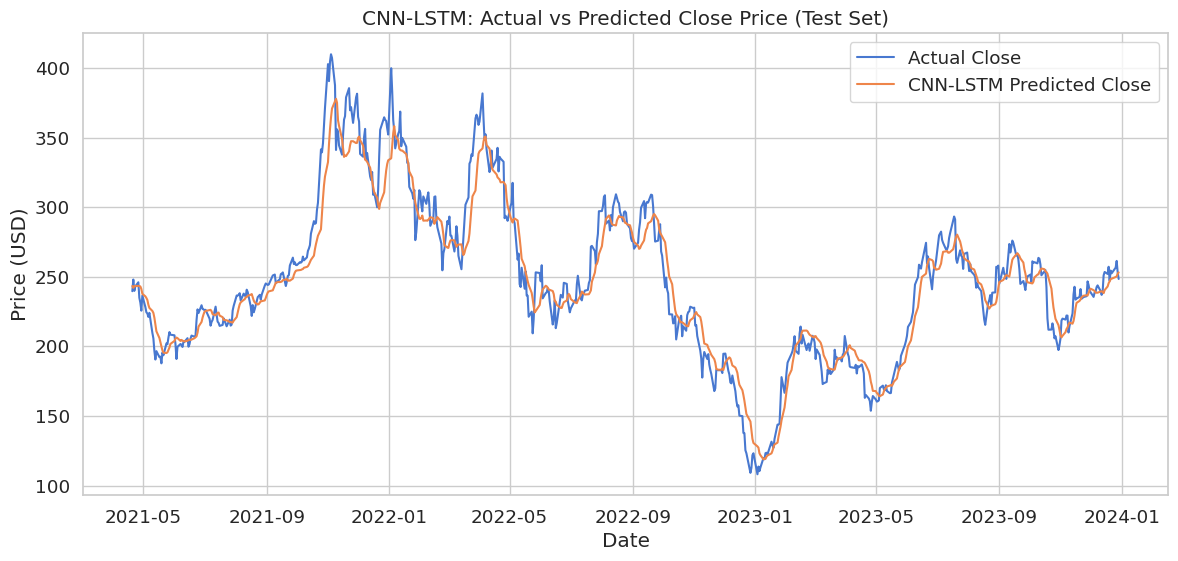

CNN-LSTM metrics appended to result.csv


In [13]:
# CNN-LSTM for Tesla stock forecasting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Step 1: Load cleaned CSV
df = pd.read_csv("tesla_stock_cleaned.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna().reset_index(drop=True)

df.set_index("Date", inplace=True)
print(df.head())

# Step 2: Select feature and target
feature_cols = ["Close"]
target_col = "Close"

series = df[feature_cols].values

train_ratio = 0.8
train_size = int(len(series) * train_ratio)

# Step 3: Scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(series[:train_size])
series_scaled = scaler.transform(series)

joblib.dump(scaler, "cnn_lstm_scaler.pkl")
print("Scaler saved.")

# Step 4: Create sequences
lookback = 60
def create_sequences(data, lookback=60):
    X, y = [], []
    N = len(data)
    for i in range(lookback, N):
        X.append(data[i - lookback:i, 0].reshape(-1,1))  # shape: (lookback, 1)
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(series_scaled, lookback)
print("Sequences shape:", X_all.shape, y_all.shape)

# Step 5: Train/test split
train_split_idx = train_size - lookback
X_train, y_train = X_all[:train_split_idx], y_all[:train_split_idx]
X_test, y_test   = X_all[train_split_idx:], y_all[train_split_idx:]

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)

# Step 6: Build CNN-LSTM model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(lookback,1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Step 7: Train model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_cnn_lstm.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

model.save("cnn_lstm_final.h5")
print("Model saved as cnn_lstm_final.h5 and best_cnn_lstm.h5")

# Step 8: Predict & Evaluate
y_pred_scaled = model.predict(X_test).reshape(-1,1)
y_true_scaled  = y_test.reshape(-1,1)

y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_true_scaled)

rmse  = np.sqrt(mean_squared_error(y_true, y_pred))
mae   = mean_absolute_error(y_true, y_pred)
mape  = np.mean(np.abs((y_true - y_pred)/y_true))*100
r2    = r2_score(y_true, y_pred)
smape = 100/len(y_true) * np.sum(2*np.abs(y_pred - y_true)/(np.abs(y_pred)+np.abs(y_true)))

print(f"CNN-LSTM RMSE : {rmse:.2f}")
print(f"CNN-LSTM MAE  : {mae:.2f}")
print(f"CNN-LSTM MAPE : {mape:.2f}%")
print(f"CNN-LSTM R2   : {r2:.4f}")
print(f"CNN-LSTM SMAPE: {smape:.2f}%")

# Step 9: Plot actual vs predicted
plt.figure(figsize=(14,6))
test_index = df.index[train_size + 0 : train_size + len(y_true)]
plt.plot(test_index, y_true, label='Actual Close')
plt.plot(test_index, y_pred, label='CNN-LSTM Predicted Close')
plt.title("CNN-LSTM: Actual vs Predicted Close Price (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Step 10: Append metrics to result.csv
metrics = {
    "Model": "CNN-LSTM",
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "SMAPE": smape
}

csv_file = "result.csv"
if os.path.exists(csv_file):
    df_metrics = pd.read_csv(csv_file)
    df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics])], ignore_index=True)
else:
    df_metrics = pd.DataFrame([metrics])

df_metrics.to_csv(csv_file, index=False)
print("CNN-LSTM metrics appended to result.csv")


## Rolling Window Evaluation

In [14]:

# Rolling Window Evaluation for CNN-LSTM
lookback = 60
window_predictions = []
window_true = []

current_idx = train_size

while current_idx + 1 <= len(series):
    if current_idx - lookback < 0:
        break
    input_seq = series_scaled[current_idx - lookback:current_idx].reshape(1, lookback, 1)

    pred_scaled = model.predict(input_seq)
    pred = scaler.inverse_transform(pred_scaled)[0,0]

    window_predictions.append(pred)
    window_true.append(series[current_idx, 0])

    current_idx += 1

window_predictions = np.array(window_predictions)
window_true = np.array(window_true)

rmse_rw  = np.sqrt(mean_squared_error(window_true, window_predictions))
mae_rw   = mean_absolute_error(window_true, window_predictions)
mape_rw  = np.mean(np.abs((window_true - window_predictions)/window_true))*100
r2_rw    = r2_score(window_true, window_predictions)
smape_rw = 100/len(window_true) * np.sum(2*np.abs(window_predictions - window_true)/(np.abs(window_predictions)+np.abs(window_true)))

print("CNN-LSTM Rolling Window Evaluation:")
print(f"RMSE  : {rmse_rw:.3f}")
print(f"MAE   : {mae_rw:.3f}")
print(f"MAPE  : {mape_rw:.3f}%")
print(f"R2    : {r2_rw:.4f}")
print(f"SMAPE : {smape_rw:.3f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

# Performance Metrics for Forecasting Models

In this project, we evaluate various forecasting models for Tesla stock prices using the following metrics: **RMSE, MAE, MAPE, R², SMAPE**. Below are the definitions, formulas, and explanations for each.

---

## 1. Root Mean Squared Error (RMSE)

**Definition:**  
RMSE measures the square root of the average squared differences between predicted and actual values. It penalizes larger errors more strongly than smaller ones.

**Formula:**

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

Where:  
- $y_i$ = actual value  
- $\hat{y}_i$ = predicted value  
- $n$ = number of observations  

**Interpretation:**  
Lower RMSE indicates better model performance. Sensitive to outliers due to squaring.

---

## 2. Mean Absolute Error (MAE)

**Definition:**  
MAE calculates the average absolute difference between predicted and actual values. Unlike RMSE, it treats all errors equally.

**Formula:**

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

**Interpretation:**  
Lower MAE means predictions are closer to actual values. Less sensitive to outliers than RMSE.

---

## 3. Mean Absolute Percentage Error (MAPE)

**Definition:**  
MAPE expresses prediction accuracy as a percentage of the actual values.  

**Formula:**

$$
\text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
$$

**Interpretation:**  
- Lower MAPE → better predictive accuracy  
- Can be problematic if $y_i = 0$ for any i

---

## 4. Coefficient of Determination (R²)

**Definition:**  
R² measures how well the predicted values explain the variance of the actual data.

**Formula:**

$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

Where $\bar{y}$ is the mean of actual values.

**Interpretation:**  
- $R^2 = 1$ → perfect prediction  
- $R^2 = 0$ → model predicts no better than the mean  
- Can be negative if model is worse than predicting the mean

---

## 5. Symmetric Mean Absolute Percentage Error (SMAPE)

**Definition:**  
SMAPE is a variation of MAPE that symmetrically penalizes over- and under-predictions.

**Formula:**

$$
\text{SMAPE} = \frac{100}{n} \sum_{i=1}^{n} \frac{ |y_i - \hat{y}_i| }{ (|y_i| + |\hat{y}_i|)/2 }
$$

**Interpretation:**  
- Values range from 0% (perfect) to 200%  
- More robust when actual values are small or zero

---

## Summary

| Metric | Description |
|--------|-------------|
| RMSE   | Square root of mean squared errors; penalizes large deviations |
| MAE    | Mean absolute difference; robust to outliers |
| MAPE   | Error as a percentage of actual values; sensitive to zeros |
| R²     | Proportion of variance explained by the model |
| SMAPE  | Symmetric version of MAPE; handles small actuals better |

---

These metrics together provide a comprehensive evaluation of forecasting models, balancing sensitivity to outliers, relative errors, and overall variance explanation.

In [90]:
import pandas as pd
df = pd.read_csv("result.csv")
numeric_cols = df.select_dtypes(include="number").columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.map(lambda y: f"{y:.3f}"))
column_colors = {
    "Model": "#FFB347",
    "RMSE": "#87CEFA",
    "MAE": "#90EE90",
    "MAPE": "#FFD700",
    "R2": "#FF69B4",
    "SMAPE": "#DA70D6"
}

styles = [
    {"selector": f"th.col{i}", "props": [("background-color", color),
                                         ("color", "black"),
                                         ("text-align", "center")]}
    for i, (col, color) in enumerate(column_colors.items())
]

df.style.set_caption("📊 Model Performance Comparison") \
        .set_table_styles(styles) \
        .set_properties(**{"text-align": "center"})

,Model,RMSE,MAE,MAPE,R2,SMAPE
0,ARIMA,58.400,44.737,19.123,-0.024,18.360
1,LSTM,13.772,10.161,4.054,0.943,4.080
2,Multivariate LSTM,13.911,10.198,4.157,0.942,4.132
3,Prophet,104.965,85.886,40.190,-2.309,31.174
4,GRU,12.378,9.259,3.752,0.954,3.754
5,CNN-LSTM,15.777,11.718,4.784,0.925,4.773


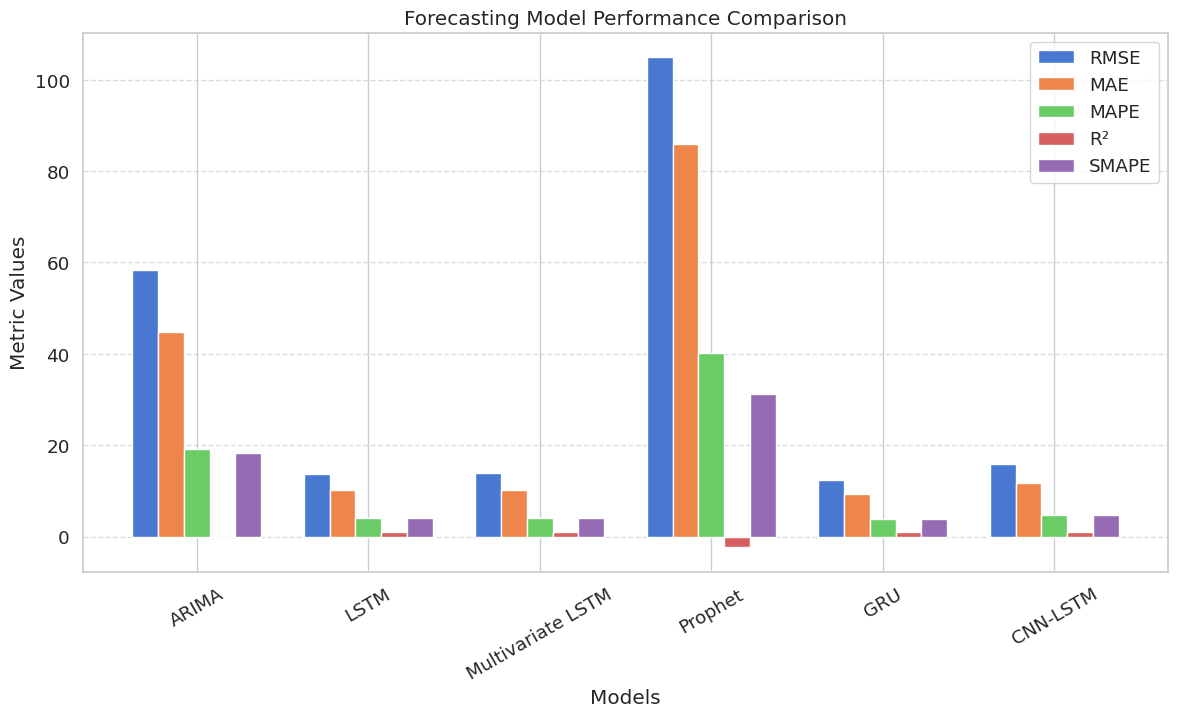

In [91]:
csv_file = "result.csv"
df = pd.read_csv(csv_file)

plt.figure(figsize=(14,7))
bar_width = 0.15
x = np.arange(len(df['Model']))

plt.bar(x - 2*bar_width, df['RMSE'], width=bar_width, label='RMSE')
plt.bar(x - bar_width, df['MAE'], width=bar_width, label='MAE')
plt.bar(x, df['MAPE'], width=bar_width, label='MAPE')
plt.bar(x + bar_width, df['R2'], width=bar_width, label='R²')
plt.bar(x + 2*bar_width, df['SMAPE'], width=bar_width, label='SMAPE')

plt.xticks(x, df['Model'], rotation=30)
plt.xlabel("Models")
plt.ylabel("Metric Values")
plt.title("Forecasting Model Performance Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

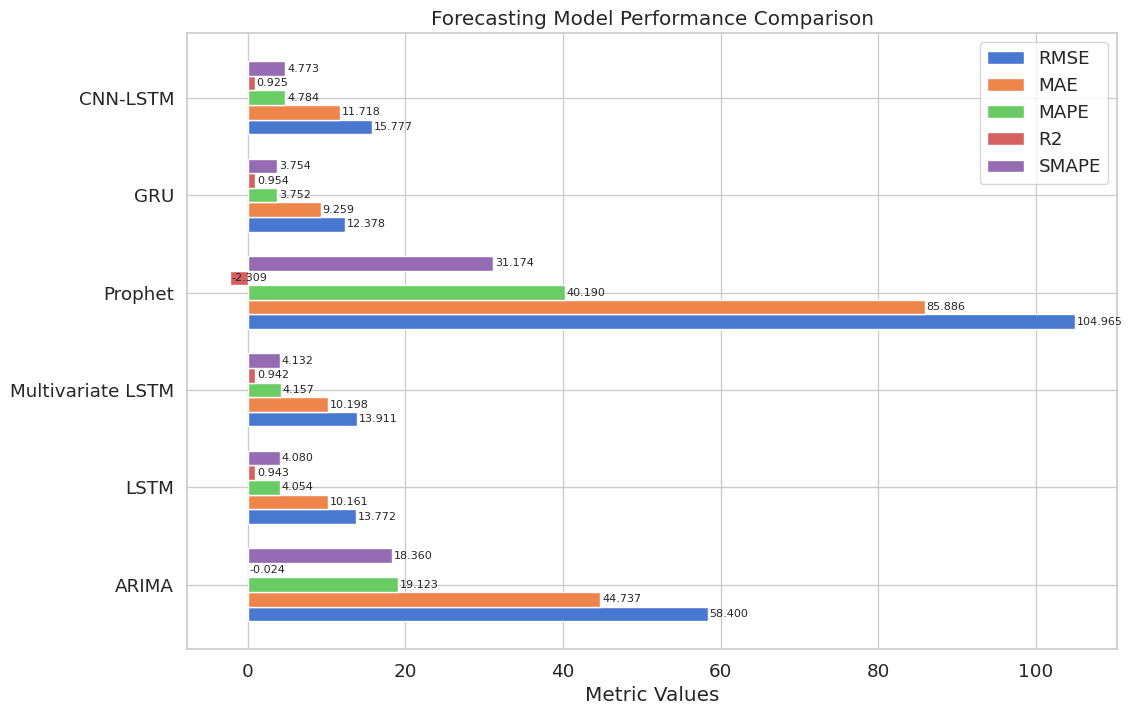

In [95]:
plt.figure(figsize=(12,8))
for i, metric in enumerate(metrics):
    plt.barh(y=np.arange(len(df))+i*0.15, width=df[metric], height=0.15, label=metric)
    for j, val in enumerate(df[metric]):
        plt.text(val + 0.2, j + i*0.15, f'{val:.3f}', va='center', fontsize=8)

plt.yticks(np.arange(len(df))+0.3, df['Model'])
plt.xlabel("Metric Values")
plt.title("Forecasting Model Performance Comparison")
plt.legend()
plt.show()

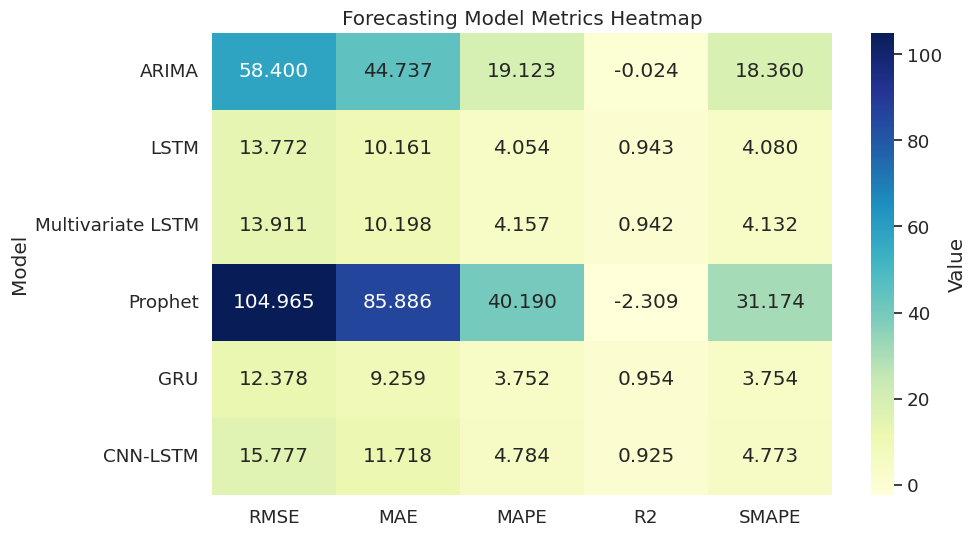

In [94]:
plt.figure(figsize=(10,6))
sns.heatmap(df.set_index('Model'), annot=True, fmt=".3f", cmap='YlGnBu', cbar_kws={'label':'Value'})
plt.title("Forecasting Model Metrics Heatmap")
plt.show()

## Rolling Window Results

In [59]:
import pandas as pd

# Define the data
data = [
    {
        "Model": "ARIMA",
        "RMSE": 9.42,
        "MAE": 6.75,
        "MAPE": 2.74,
        "SMAPE": 2.73,
        "R2": 0.9733
    },
    {
        "Model": "LSTM",
        "RMSE": 68.1963,
        "MAE": 52.8509,
        "MAPE": 20.47,
        "SMAPE": 21.97,
        "R2": -0.3966
    },
    {
        "Model": "Multivariate LSTM",
        "RMSE": 14.9777,
        "MAE": 11.0079,
        "MAPE": 4.49,
        "SMAPE": 4.46,
        "R2": 0.9326
    },
    {
        "Model": "Prophet",
        "RMSE": 78.9953,
        "MAE": 59.6115,
        "MAPE": 29.04,
        "SMAPE": 22.63,
        "R2": -0.8740
    },
    {
        "Model": "GRU",
        "RMSE": 12.3783,
        "MAE": 9.2585,
        "MAPE": 3.75,
        "SMAPE": 3.75,
        "R2": 0.9540
    },
    {
        "Model": "CNN-LSTM",
        "RMSE": 15.777,
        "MAE": 11.718,
        "MAPE": 4.784,
        "SMAPE": 4.773,
        "R2": 0.9253
    }
]

df_metrics = pd.DataFrame(data)

df_metrics.to_csv("rolling_window_metrics.csv", index=False)
print("CSV saved as rolling_window_metrics.csv")


CSV saved as rolling_window_metrics.csv


In [60]:
import pandas as pd
df = pd.read_csv("/content/rolling_window_metrics.csv")
numeric_cols = df.select_dtypes(include="number").columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.map(lambda y: f"{y:.3f}"))
column_colors = {
    "Model": "#FFB347",
    "RMSE": "#87CEFA",
    "MAE": "#90EE90",
    "MAPE": "#FFD700",
    "R2": "#FF69B4",
    "SMAPE": "#DA70D6"
}

styles = [
    {"selector": f"th.col{i}", "props": [("background-color", color),
                                         ("color", "black"),
                                         ("text-align", "center")]}
    for i, (col, color) in enumerate(column_colors.items())
]

df.style.set_caption("📊 Model Performance Comparison") \
        .set_table_styles(styles) \
        .set_properties(**{"text-align": "center"})

,Model,RMSE,MAE,MAPE,SMAPE,R2
0,ARIMA,9.420,6.750,2.740,2.730,0.973
1,LSTM,68.196,52.851,20.470,21.970,-0.397
2,Multivariate LSTM,14.978,11.008,4.490,4.460,0.933
3,Prophet,78.995,59.611,29.040,22.630,-0.874
4,GRU,12.378,9.258,3.750,3.750,0.954
5,CNN-LSTM,15.777,11.718,4.784,4.773,0.925


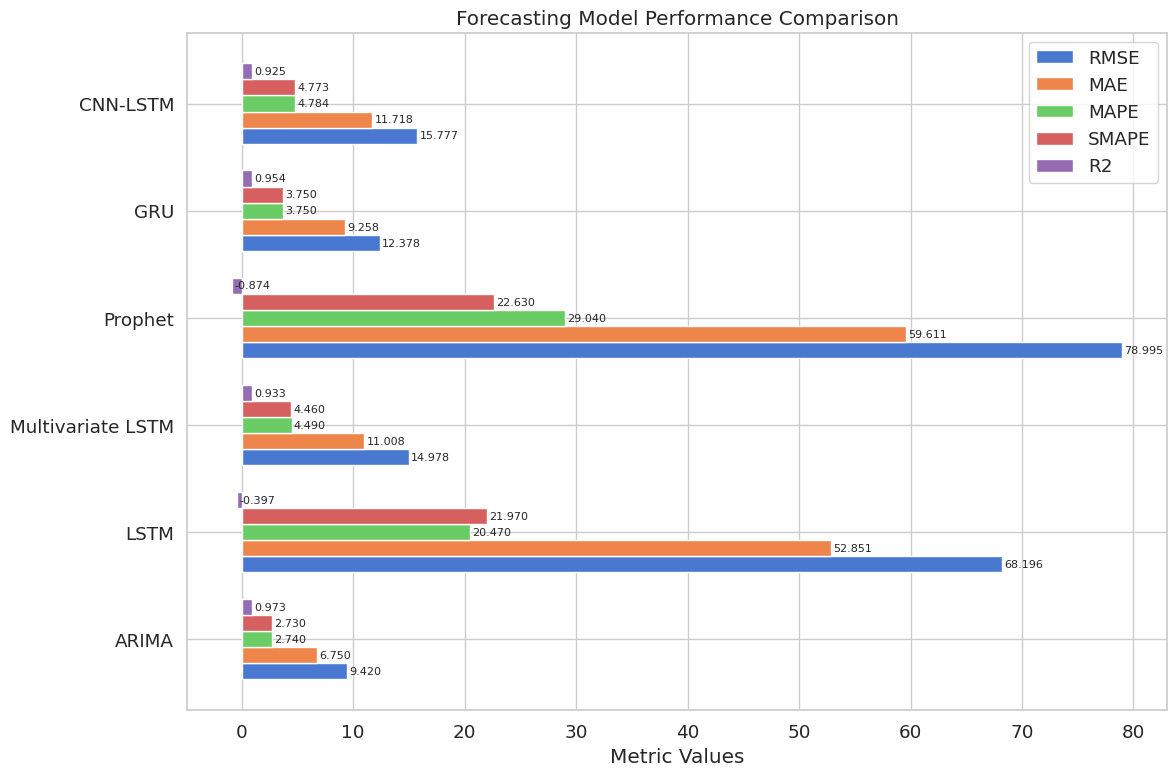

In [63]:

df = pd.read_csv("/content/rolling_window_metrics.csv")

metrics = ["RMSE", "MAE", "MAPE", "SMAPE", "R2"]
for m in metrics:
    df[m] = df[m].astype(float)

plt.figure(figsize=(12, 8))
bar_height = 0.15

for i, metric in enumerate(metrics):
    plt.barh(y=np.arange(len(df)) + i*bar_height, width=df[metric], height=bar_height, label=metric)
    for j, val in enumerate(df[metric]):
        plt.text(val + 0.2, j + i*bar_height, f'{val:.3f}', va='center', fontsize=8)

plt.yticks(np.arange(len(df)) + bar_height*(len(metrics)-1)/2, df['Model'])
plt.xlabel("Metric Values")
plt.title("Forecasting Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()


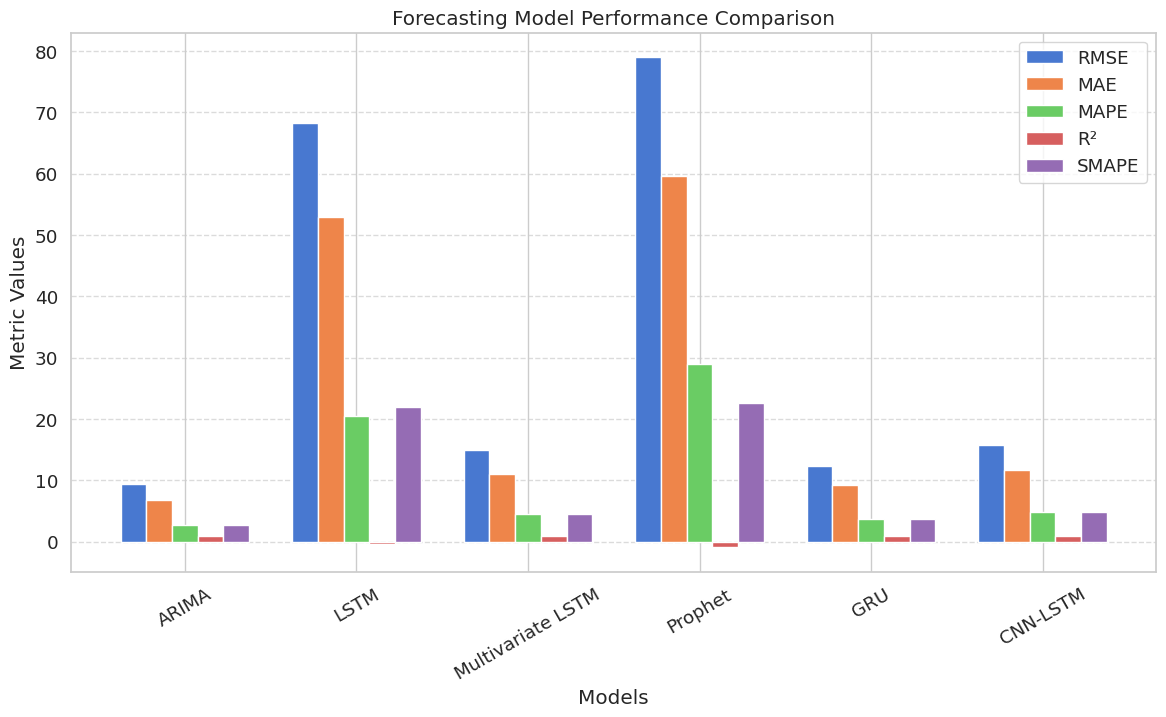

In [64]:
csv_file = "/content/rolling_window_metrics.csv"
df = pd.read_csv(csv_file)

plt.figure(figsize=(14,7))
bar_width = 0.15
x = np.arange(len(df['Model']))

plt.bar(x - 2*bar_width, df['RMSE'], width=bar_width, label='RMSE')
plt.bar(x - bar_width, df['MAE'], width=bar_width, label='MAE')
plt.bar(x, df['MAPE'], width=bar_width, label='MAPE')
plt.bar(x + bar_width, df['R2'], width=bar_width, label='R²')
plt.bar(x + 2*bar_width, df['SMAPE'], width=bar_width, label='SMAPE')

plt.xticks(x, df['Model'], rotation=30)
plt.xlabel("Models")
plt.ylabel("Metric Values")
plt.title("Forecasting Model Performance Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()